## Consistency with smartseq data:

1. Contaminated programs (8)
2.  exhausted vs. memory analysis (2)
3. repeating the ranksum tests on treatments subgroups (2)
4. robust test of differential expression by discovering and cross validation (3)
5. identify the % of organ cells in each biopsy (5)
6. plot a histogram of the number of T-cells; Myeloids and B-cells for example across the entire cohort (6)
7. Comparing non-responder immune markers with smartseq2 study (7)



In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats
import warnings 
warnings.filterwarnings("ignore")

In [2]:
def get_pvals(group_fractions):
    pvals = []
    for cluster in set(group_fractions["cluster"]):
        cluster_df = group_fractions[group_fractions["cluster"] == cluster]
        R_fractions = cluster_df[cluster_df["Response"] == 'R']['sample_fraction'].values
        NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['sample_fraction'].values
        res = ranksums(R_fractions, NR_fractions)[1]
        pvals.append([cluster, res])
    pvals = np.array(pvals)

    # Correct pvals
    corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T
    return pvals, corrected_pvals

# 1. Contaminated programs (8)

Contaminated programs:
4 is stroma and should be removed, 17 is B cells and should be removed, and 14 is probably tumor cells that have gone phagocytosis by macrophages

In [101]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_5.5.22'

selected_K = 21
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '21'

In [102]:
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
normalized_usage_matrix.head()

normalized_usage_matrix = normalized_usage_matrix.reset_index()

normalized_usage_matrix['sample'] = normalized_usage_matrix['index'].apply(lambda x: x.split('_')[0])
normalized_usage_matrix['barcode'] = normalized_usage_matrix['index'].apply(lambda x: x.split('_')[1])
normalized_usage_matrix = normalized_usage_matrix.drop(columns=['index'])#.set_index(['sample', 'barcode'])

See the % of cells in each usage level in program #14:

In [103]:
PROG_IDX = 20


{f'Usage {round(k*100)}%': f'{round(v/len(normalized_usage_matrix)*100,2)}% of the cells' for k,v in sort_dic(Counter(round(normalized_usage_matrix[PROG_IDX], 1))).items()}

{'Usage 0%': '60.91% of the cells',
 'Usage 10%': '19.72% of the cells',
 'Usage 20%': '8.33% of the cells',
 'Usage 30%': '3.55% of the cells',
 'Usage 40%': '2.66% of the cells',
 'Usage 50%': '2.09% of the cells',
 'Usage 60%': '1.47% of the cells',
 'Usage 70%': '0.85% of the cells',
 'Usage 80%': '0.35% of the cells',
 'Usage 90%': '0.06% of the cells',
 'Usage 100%': '0.0% of the cells'}

In [104]:
PROG_IDX = 20
usage_threshold = 0.1

print(f'% of tumor cells: {sum(normalized_usage_matrix[PROG_IDX] > usage_threshold) / len(normalized_usage_matrix)}')
print(f'# of tumor cells: {sum(normalized_usage_matrix[PROG_IDX] > usage_threshold)}')

% of tumor cells: 0.2729166191572978
# of tumor cells: 35903


Analyze these cells:

In [9]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)

In [11]:
# take cells with % usage > 0.2 in program #14:
prog_idx = 16
usage_threshold = 0.2

identifiers = normalized_usage_matrix[normalized_usage_matrix[prog_idx]>usage_threshold]
subcohort = tumor_cohort.get_subset_by_identifiers(identifiers['sample'], identifiers.barcode)
print(f'number of cells in subcohort: {subcohort.number_of_cells}')

number of cells in subcohort: 25909


In [12]:
# print(subcohort.cells_information.getattr('cell_type_list'))
# print(subcohort.cells_information.getattr('conflict_related_cell_types'))
print(f'1. apoptosis cells: {sum(subcohort.cells_information.getattr("is_apoptosis"))}')
print(f'2. immune cells: {sum(subcohort.cells_information.getattr("is_immune"))}')
print(f'3. tumor cells: {sum(subcohort.cells_information.getattr("is_cancer"))}')
print(f'4. tumor & immune conflicts: {sum(subcohort.cells_information.getattr("cancer_immune_conflict"))}')
print(f'5. doublets: {sum(subcohort.cells_information.getattr("is_doublet"))}')
print(f'6. lymphoids: {sum(subcohort.cells_information.getattr("is_lymphoid"))}')
print(f'7. myeloids: {sum(subcohort.cells_information.getattr("is_myeloid"))}')
print(f'8. CelBender_empty: {sum(subcohort.cells_information.getattr("is_CelBender_empty"))}')
print(f'9. stromal: {sum(subcohort.cells_information.getattr("is_stromal"))}')
print(f'10. epithelial: {sum(subcohort.cells_information.getattr("is_epithelial"))}')
print(f'11. should_be_removed: {sum(subcohort.cells_information.getattr("should_be_removed"))}')
print(f'12. Comments: {dict(Counter(subcohort.cells_information.getattr("comment")))}')
# print(f'13 {(subcohort.cells_information.getattr("is_responder"))}')

1. apoptosis cells: 0
2. immune cells: 0
3. tumor cells: 25909
4. tumor & immune conflicts: 0
5. doublets: 113
6. lymphoids: 0
7. myeloids: 0
8. CelBender_empty: 1051
9. stromal: 0
10. epithelial: 0
11. should_be_removed: 0
12. Comments: {None: 23545, '10.6.21 tumor cells with immune markers that may be on tumor cells': 2364}


#### 1. Define all contaminated programs and cells:
 
Probelamtic clusters are:

13- myeloid

14- myeloid

17- B cells

As for cluster 4, this could also be a MET transition program. 

In [16]:
usage_threshold = 0.1

filtered_indices = (normalized_usage_matrix[13] > usage_threshold) | (normalized_usage_matrix[14] > usage_threshold) | (normalized_usage_matrix[17] > usage_threshold)
contaminated_df = normalized_usage_matrix[filtered_indices]
# contaminated_df[['sample', 'barcode']]

print(f'Number of tumor cells in current cohort:   {tumor_cohort.number_of_cells}')
print(f'Number of tumor cells in cohort:           {len(normalized_usage_matrix)} (before subcohort contaminated tumor cells deletion)')
print(f'Number of contaminated tumor cells:        {len(contaminated_df)}')
print(f'% of contaminated tumor cells:             {len(contaminated_df)/len(normalized_usage_matrix)}')

Number of tumor cells in current cohort:   131553
Number of tumor cells in cohort:           157733 (before subcohort contaminated tumor cells deletion)
Number of contaminated tumor cells:        26180
% of contaminated tumor cells:             0.16597668211471284


In [130]:
contaminated_df.to_csv(r'/storage/md_keren/shitay/Data/tables/GEP/contaminated_cells_list/cohort_4.11.21_GEP13_GEP14_GEP17_contaminated_cells.csv')

### 4.2. Create new cohort 
A new version of the cohort identical to the previous version (from 4.11.22) except of contaminated cells (GEP #13, #14 and #17 cells) that will not be there.

cohort -

* /storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/non_normalized
* /storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/normalized
* all files from 4.11.21, will be updated to 5.5.22


In [10]:
# COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21/cohort_normalized_4.11.21_protein_coding_genes.pkl'
# cohort = pickle.load(open(COHORT_PATH, 'rb'))
contaminated_df = pd.read_csv(r'/storage/md_keren/shitay/Data/tables/GEP/contaminated_cells_list/cohort_4.11.21_GEP13_GEP14_GEP17_contaminated_cells.csv')

filter cohort from contaminated cells. Go through all cohort files and in each of them filter out contaminated cells:

In [5]:
DATA_ROOT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort'
NORMALIZATION_MODES = ['non_normalized', 'normalized']

for nor_mode in NORMALIZATION_MODES:
    existing_pkls_folder = join(DATA_ROOT_PATH, nor_mode, '4.11.21')
    
    dest_folder = join(DATA_ROOT_PATH, nor_mode, '5.5.22')

    print(existing_pkls_folder)
    print(dest_folder)
    create_folder(dest_folder)
    print('pkl files:')
    for pkl_file_name in os.listdir(existing_pkls_folder):
        if 'immune' in pkl_file_name or 'protein_coding' in pkl_file_name:
            continue
        pkl_file_path = join(existing_pkls_folder, pkl_file_name)
        dest_file_path = join(dest_folder, pkl_file_name).replace('4.11.21', '5.5.22')
        print(f'source {pkl_file_path}')
        print(f'dest {dest_file_path}')

        curr_cohort = pickle.load(open(pkl_file_path, 'rb'))
        filtered_cohort = curr_cohort.filter_cohort_from(contaminated_df['sample'], contaminated_df['barcode'])
        pickle.dump((filtered_cohort), open(dest_file_path, 'wb'), protocol=4)

    print(end='\n\n')

/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/non_normalized/4.11.21
/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/non_normalized/5.5.22
pkl files:
source /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/non_normalized/4.11.21/cohort_non_normalized_4.11.21.pkl
dest /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/non_normalized/5.5.22/cohort_non_normalized_5.5.22.pkl


/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21
/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22
folder: /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22 has been created
pkl files:
source /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21/cohort_normalized_4.11.21.pkl
dest /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22.pkl




In [13]:
cohort.number_of_cells

310027

#### Sanity Check of the cohort saved:

In [10]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)

In [31]:
x1 = [tuple(aa) for aa in contaminated_df[['sample', 'barcode']].values.tolist()]
x2 = list(zip(tumor_cohort.samples, tumor_cohort.barcodes))
print(f'It is consistent: {len([bb for bb in x1 if bb in x2])==0}')

It is consistent: True


In [35]:
subcohort_contaminated_cells = pd.read_csv(r'/storage/md_keren/shitay/Data/tables/GEP/contaminated_cells_list/subcohort_1.1.22_GEP14_contaminated_cells.csv')[['sample', 'barcode']]


In [39]:
x1 = [tuple(aa) for aa in contaminated_df[['sample', 'barcode']].values.tolist()]
x2 = [tuple(aa) for aa in subcohort_contaminated_cells[['sample', 'barcode']].values.tolist()]
print(f'subcohort overlap: {len([bb for bb in x1 if bb in x2])} out of {len(x2)}')

subcohort overlap: 2426 out of 2659


#  2.  Exhausted vs. Memory (2)


#### part 1: Find two clusters of CD8 and conduct differential expression analysis:

In [3]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/immune_cells_normalized_5.5.22_4k_genes.pkl'
print(f'Loading cohort from:\n{COHORT_PATH}')

cohort = pickle.load(open(COHORT_PATH, 'rb'))
CD8_cohort = get_requested_subset(cohort, 'CYTOTOXIC_T_CELLS')


Loading cohort from:
/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/immune_cells_normalized_5.5.22_4k_genes.pkl
Will be performed on cytotoxic T cells


In [4]:
CD8_cohort.number_of_cells

42211

In [8]:
CD8_k_2_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/kmeans/cohort_16.3.22_run_29.4.22/barcode_mapping/kmeans_immune_cells_4k_genes_k_2_clusters_mapping.csv'
clustering_mapping = pd.read_csv(CD8_k_2_PATH)
Cluster_1_df = clustering_mapping[clustering_mapping.Cluster==1]
Cluster_2_df = clustering_mapping[clustering_mapping.Cluster==2]

In [6]:
cohort_cluster1 = CD8_cohort.get_subset_by_identifiers(Cluster_1_df['Sample'], Cluster_1_df['Barcode'])
cohort_cluster2 = CD8_cohort.get_subset_by_identifiers(Cluster_2_df['Sample'], Cluster_2_df['Barcode'])

cluster_1_markers = find_satisfying_list_of_markers_in_cluster(cohort_cluster1, cohort_cluster2, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                              min_pct=0.1, min_diff_pct=0.1, min_mean_exp=1, min_markers=30)
cluster_2_markers = find_satisfying_list_of_markers_in_cluster(cohort_cluster2, cohort_cluster1, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                              min_pct=0.1, min_diff_pct=0.1, min_mean_exp=1, min_markers=30)



In [9]:
cluster_1_markers.to_csv(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/cluster_1_markers.csv')
cluster_2_markers.to_csv(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/cluster_2_markers.csv')

#### part 2: Check overlap of droplet two cluster CD8 markers with smartseq ones:

 CD8_G with increased expression of genes linked to memory, activation and cell survival (e.g. IL7R, TCF7, REL, FOXP1, FOSL2 and STAT4) (Hurton et al., 2016) and reduced expression of co-inhibitory molecules;
 
 CD8_B enriched for genes linked to cell exhaustion (e.g. CD38, HAVCR2, ENTPD1, PDCD1, BATF, LAG3, CTLA4 and PTPN6)

In [3]:
cluster_1_markers = pd.read_csv(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/cluster_1_markers.csv')
cluster_2_markers = pd.read_csv(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/cluster_2_markers.csv')

In [4]:
smartseq_CD8_B_markers = pd.read_excel(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/smartseq_equivalent_markers/smartseq_CD8_markers.xlsx', sheet_name='CD8_B', header=1)
smartseq_CD8_G_markers = pd.read_excel(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/smartseq_equivalent_markers/smartseq_CD8_markers.xlsx', sheet_name='CD8_G', header=1)

In [5]:
cl1_clG = intersection_of_lists(cluster_1_markers['gene names'], smartseq_CD8_G_markers['GeneName'])
cl1_clB = intersection_of_lists(cluster_1_markers['gene names'], smartseq_CD8_B_markers['GeneName'])
cl2_clG = intersection_of_lists(cluster_2_markers['gene names'], smartseq_CD8_G_markers['GeneName'])
cl2_clB = intersection_of_lists(cluster_2_markers['gene names'], smartseq_CD8_B_markers['GeneName'])

In [39]:
# cl1_clG - memory
# cl2_clB - exhausted
# (e.g. CD38, HAVCR2, ENTPD1, PDCD1, BATF, LAG3, CTLA4 and PTPN6)
genes = ['CD38', 'HAVCR2', 'ENTPD1', 'PDCD1', 'BATF', 'LAG3', 'CTLA4', 'PTPN6']
reuired_genes = ['TIM3', 'CTLA4', 'PDCD1', 'HAVCR2']
[g for g in reuired_genes if g in cl2_clB]
# [g for g in reuired_genes if g in cluster_2_markers['gene names'].tolist()]
# [g for g in reuired_genes if g in smartseq_CD8_B_markers['GeneName'].tolist()]
# cl2_clB


[]

In [6]:
print(f'Number of markers in cl1: {len(cluster_1_markers)}')
print(f'Number of markers in cl2: {len(cluster_2_markers)}')
print(f'Number of markers in CD8_G: {len(smartseq_CD8_G_markers)}')
print(f'Number of markers in CD8_B: {len(smartseq_CD8_B_markers)}')
print()

print(f'len of overlap cl1_clG: {len(cl1_clG)}')
print(f'len of overlap cl1_clB: {len(cl1_clB)}')
print(f'len of overlap cl2_clG: {len(cl2_clG)}')
print(f'len of overlap cl2_clB: {len(cl2_clB)}')

Number of markers in cl1: 44
Number of markers in cl2: 159
Number of markers in CD8_G: 34
Number of markers in CD8_B: 1114

len of overlap cl1_clG: 10
len of overlap cl1_clB: 0
len of overlap cl2_clG: 0
len of overlap cl2_clB: 125


In [7]:
cluster_1_markers.head()

Unnamed: 0         features gene names  (1)mean_expression  \
0         411  ENSG00000081059       TCF7            0.554857   
1        3049  ENSG00000168685       IL7R            1.939352   
2        3617  ENSG00000188404       SELL            0.802824   
3        3911  ENSG00000227507        LTB            1.414130   
4        1123  ENSG00000111913     FAM65B            0.434787   

   (2)mean_expression    log_FC  (1)#expressing  (2)#expressing  \
0            0.057905  3.056292            3821             700   
1            0.245483  2.931693            9352            2348   
2            0.180717  2.091507            4886            2062   
3            0.397552  1.805025            7528            3808   
4            0.137796  1.589509            3123            1581   

   (1)%expressing  (2)%expressing  %expressing_diff          pvals  
0        0.222825        0.027930          0.194895   0.000000e+00  
1        0.545370        0.093684          0.451686   0.000000e+00  
2        0.284931        0.082273          0.202659   0.000000e+00  
3        0.439002        0.151937          0.287065   0.000000e+00  
4        0.182120        0.063081          0.119039  1.611952e-312

#### part 3: ranksum and bar plot for each of the clusters and check if there are more memory in R and more exhausted in NR. Is it significant? If not, do we see a trend.

##### 3.1. Option 1: entire cohort:

In [5]:
melanoma_clinical_data = get_clinical_data(71, ICI=True)


res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')
print(f'Num of samples in table is {len(melanoma_clinical_data)}')
# display(melanoma_clinical_data.head(20).reset_index())#.drop(columns=['index', 'level_0']))
res_melanoma_clinical_data['response'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv
Num of samples in table is 53


NR                    31
R                     18
not in use for now     4
Name: response, dtype: int64

##### 3.2. Option 2: homogeneous dataset:

In [20]:
melanoma_clinical_data = get_clinical_data(n_samples=71, ICI=True, melanoma_type=['Cutaneous'], therapy_translator=seperate_IPI_from_NIVO_translator, additional_features=['Biopsy type (pre, post)'], time_translator=pre_pro_translator)
melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['response'] != 'not in use for now']                    
melanoma_clinical_data = melanoma_clinical_data.drop(columns=['ICI', 'BRAF', 'Biopsy type (pre, post)']).reset_index(drop=True).rename(columns={'prior to biopsy':'treatment_before', 'after biopsy':'treatment_after'})
melanoma_clinical_data['treatment'] = melanoma_clinical_data.apply(lambda x: x.treatment_after if x['pre/post']=='Pre' else x.treatment_before, axis=1)

melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data.treatment=='NIVO'].reset_index(drop=True)
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')
res_melanoma_clinical_data['response'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv


R     11
NR     7
Name: response, dtype: int64

In [21]:
CD8_cluster_fraction = get_cluster_fraction_df(clustering_mapping)

In [22]:
CD8_cluster_fraction = CD8_cluster_fraction[CD8_cluster_fraction["sample"].isin(melanoma_clinical_data['Patient id'])]
CD8_cluster_fraction['Response'] = CD8_cluster_fraction['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])
CD8_cluster_fraction = CD8_cluster_fraction[CD8_cluster_fraction.Response !='not in use for now']

In [23]:
CD8_cluster_fraction.pivot_table(index=['sample', 'Response'], columns='cluster').to_csv(f'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/CD8_clusters_fractions.csv')

In [24]:
pvals = []
for cluster in set(CD8_cluster_fraction["cluster"]):
    print(f'cluster {cluster}')
    cluster_df = CD8_cluster_fraction[CD8_cluster_fraction["cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['sample_fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['sample_fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    print(f'pval {res}')
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T
print()
print(f'Corrected pvals:')
print(corrected_pvals)

cluster 1
pval 0.2048216795773823
cluster 2
pval 0.2048216795773823

Corrected pvals:
[[1.         0.27309557]
 [2.         0.27309557]]


cluster1 (CD8_G):  memory
cluster2 (CD8_B):  exhaustion


<Figure size 480x240 with 0 Axes>

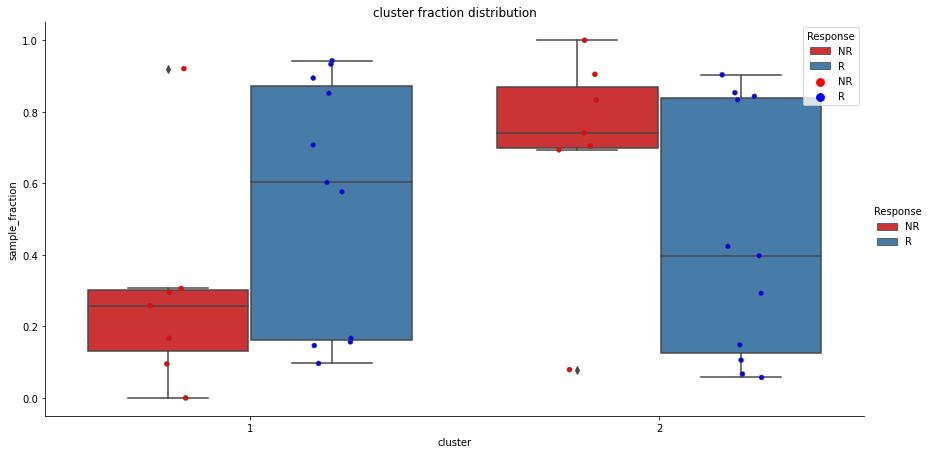

In [25]:
fig = plt.figure(figsize=(6, 3), dpi=80);
sns.reset_orig();
# full_sample_fractions_df['cluster'] = full_sample_fractions_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
# full_sample_fractions_df = full_sample_fractions_df.sort_values('Cluster')
ax = sns.catplot(kind="box", x='cluster', y='sample_fraction', hue='Response', data=CD8_cluster_fraction, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution");
sns.stripplot(x='cluster', y='sample_fraction', hue='Response', data=CD8_cluster_fraction,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
print(f'cluster1 (CD8_G):  memory\ncluster2 (CD8_B):  exhaustion')

log10 ratio of number of cells in memory_cluster compared to exausted_cluster per sample for responder and non-responder lesions.

In [32]:
ratio_clusters_df = clustering_mapping.groupby(['Sample', 'Cluster']).count().reset_index().pivot_table(index='Sample', columns='Cluster').reset_index().rename(columns={( 'Sample', ''):'Sample'})
ratio_clusters_df['ratio'] = ratio_clusters_df[('Barcode', 1)] / ratio_clusters_df[('Barcode', 2)]
ratio_clusters_df = ratio_clusters_df[ratio_clusters_df['Sample'].isin(melanoma_clinical_data['Patient id'])]
ratio_clusters_df['Response'] = ratio_clusters_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])
ratio_clusters_df = ratio_clusters_df[ratio_clusters_df.Response !='not in use for now']
ratio_clusters_df = ratio_clusters_df.dropna()
ratio_clusters_df['memory/exhaustion ratio (log10)'] = np.log10(ratio_clusters_df.ratio)


In [33]:
# pd.set_option('display.max_rows', 10)
# clustering_mapping.groupby(['Sample', 'Cluster']).count().reset_index().pivot_table(index='Sample', columns='Cluster').reset_index().rename(columns={( 'Sample', ''):'Sample'})

In [35]:
ranksums(ratio_clusters_df[ratio_clusters_df.Response=='NR']['memory/exhaustion ratio (log10)'], ratio_clusters_df[ratio_clusters_df.Response=='R']['memory/exhaustion ratio (log10)'])

RanksumsResult(statistic=-0.8542821429703302, pvalue=0.3929486789354336)

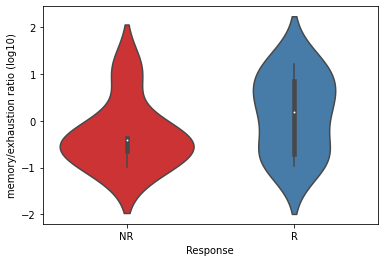

In [45]:
ax = sns.violinplot(kind="box", y='memory/exhaustion ratio (log10)', x='Response', data=ratio_clusters_df, palette="Set1",height=6, aspect=2.0)#.set(title="log10 ratio of number of cells in memory_cluster compared to exausted_cluster per sample for responder and non-responder lesions");
ax.get_figure().savefig(r'/storage/md_keren/shitay/outputs/thesis/clustering/mem_exh_CD8/log10_ratio.jpg')

cluster1 (CD8_G):  memory

cluster2 (CD8_B):  exhaustion

#### part 4: AUC

In [30]:
import numpy as np
from sklearn import metrics

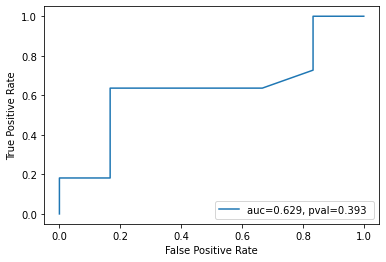

In [50]:
y = ratio_clusters_df.Response.apply(lambda x: 1 if x=='NR' else 2).values
pred = ratio_clusters_df['memory/exhaustion ratio (log10)'].values
# pred = (pred - min(pred)) / (max(pred) - min(pred))

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
pval = ranksums(ratio_clusters_df[ratio_clusters_df.Response=='NR']['memory/exhaustion ratio (log10)'], ratio_clusters_df[ratio_clusters_df.Response=='R']['memory/exhaustion ratio (log10)'])[1]

auc = metrics.roc_auc_score(y, pred)
plt.plot(fpr,tpr,label=f"auc={round(auc, 3)}, pval={round(pval, 3)} ")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.savefig(r'/storage/md_keren/shitay/outputs/thesis/clustering/mem_exh_CD8/AUC_curve.jpg')
plt.show()

##### part 5: TSNE these clusters

In [51]:
# clustering_mapping
TSNE_PATH = r'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/CD8/CD8_bhtsne_5.5.22.csv'
tsne_df = pd.read_csv(TSNE_PATH)


In [53]:
# other_samples_tsne_df = tsne_df[~tsne_df.Sample.isin(res_melanoma_clinical_data.index.tolist())]
# patient_id = 'M104'


# tsne_df.merge(clustering_mapping[clustering_mapping.Cluster==1], how='inner', on=['Barcode', 'Sample'])

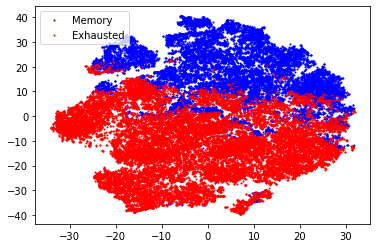

In [57]:
# cluster_1_tsne_df = tsne_df[tsne_df.Barcode.isin(clustering_mapping[(clustering_mapping.Sample==patient_id) & (clustering_mapping.Cluster==1)].Barcode)]
cluster_1_tsne_df = tsne_df.merge(clustering_mapping[clustering_mapping.Cluster==1], how='inner', on=['Barcode', 'Sample'])
cluster_2_tsne_df = tsne_df.merge(clustering_mapping[clustering_mapping.Cluster==2], how='inner', on=['Barcode', 'Sample'])
plt.plot(cluster_1_tsne_df[['x', 'y']].values[:,0], cluster_1_tsne_df[['x', 'y']].values[:,1], 'ro', color='b', label='Memory', markersize=1);
plt.plot(cluster_2_tsne_df[['x', 'y']].values[:,0], cluster_2_tsne_df[['x', 'y']].values[:,1], 'ro', label='Exhausted', markersize=1);
plt.legend();
plt.legend(loc='upper left');
plt.savefig(r'/storage/md_keren/shitay/outputs/thesis/clustering/mem_exh_CD8/tsne_mem_exh_CD8.jpg')


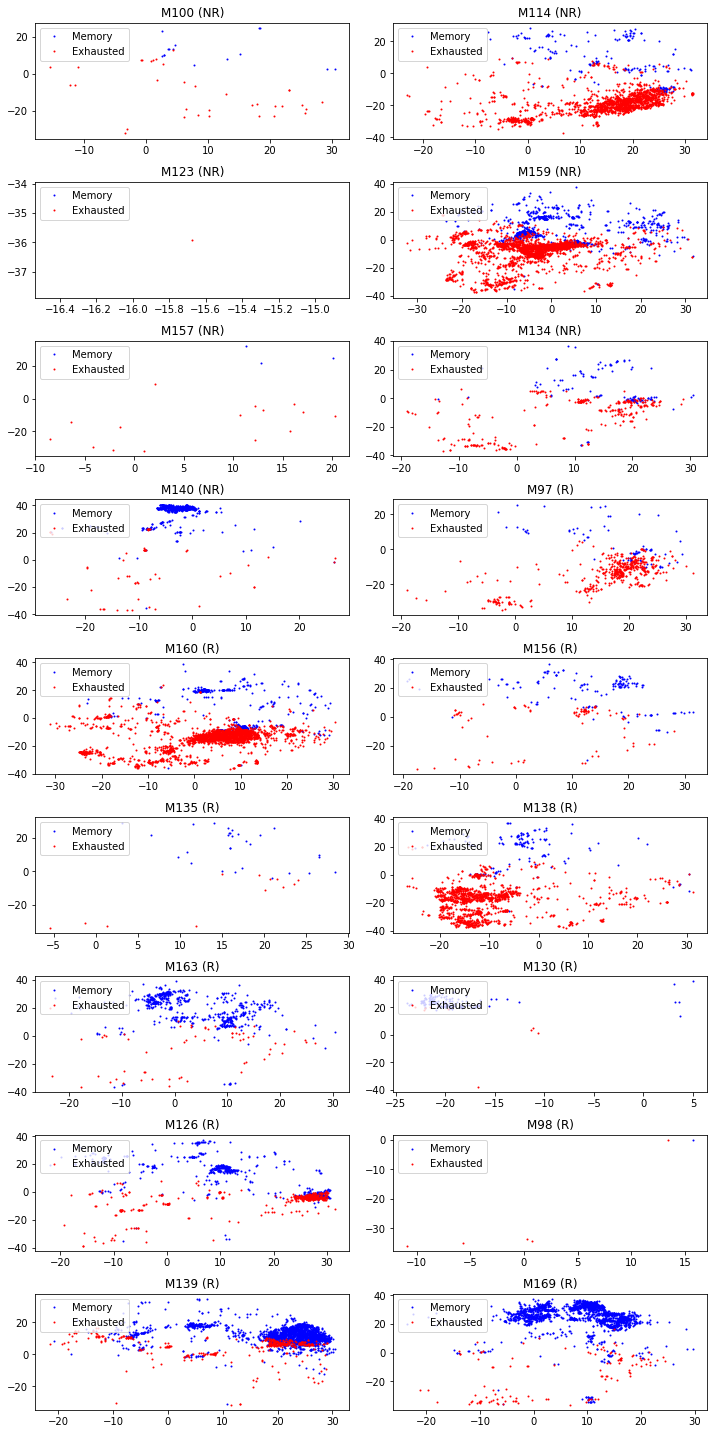

In [60]:
(fig,axes) = plt.subplots(int(len(set(melanoma_clinical_data['Patient id']))/2), 2, figsize=(10, 20))
axes = axes.ravel()
history_print_patients = []
for i, patient_id in enumerate(melanoma_clinical_data.sort_values('response')['Patient id']):
#     if patient_id in history_print_patients:
#         continue
    history_print_patients.append(patient_id)
    cluster_1_sample_tsne_df = tsne_df[(tsne_df.Sample==patient_id) & tsne_df.Barcode.isin(clustering_mapping[(clustering_mapping.Sample==patient_id) & (clustering_mapping.Cluster==1)].Barcode)]
    cluster_2_sample_tsne_df = tsne_df[(tsne_df.Sample==patient_id) & tsne_df.Barcode.isin(clustering_mapping[(clustering_mapping.Sample==patient_id) & (clustering_mapping.Cluster==2)].Barcode)]
    other_samples_tsne_df = tsne_df[tsne_df.Sample!=patient_id]
    axes[i].plot(cluster_1_sample_tsne_df[['x', 'y']].values[:,0], cluster_1_sample_tsne_df[['x', 'y']].values[:,1], 'ro', color='b', label='Memory', markersize=1);
    axes[i].plot(cluster_2_sample_tsne_df[['x', 'y']].values[:,0], cluster_2_sample_tsne_df[['x', 'y']].values[:,1], 'ro', label='Exhausted', markersize=1);
#     axes[i].plot(other_samples_tsne_df[['x', 'y']].values[:,0], other_samples_tsne_df[['x', 'y']].values[:,1], 'ro', color='gray', label='-', markersize=1);
    axes[i].set(title=f"{patient_id} ({res_melanoma_clinical_data.loc[patient_id].response})");
    axes[i].legend(loc='upper left');
plt.tight_layout(pad=1)
plt.savefig(r'/storage/md_keren/shitay/outputs/thesis/clustering/mem_exh_CD8/tsne_mem_exh_CD8_cutaneous_samples_treated_with_PD1.jpg')

# 3. repeating the ranksum tests on treatments subgroups (2)


Question raised:
How to label pre/post of # M130 M132 M137 M163 in clinical table?


Divide the cutaneous patients into groups: 

A. Those who got only PD1 (NIVO), and then divide them to pre and post

B. Those who got IPI and NIVO, and then divide them to pre and post

Then, it's simply repeating the ranksum tests on these subgroups and see if the signal changes, not a big deal.


In [1]:
cutaneous_melanoma_clinical_data = get_clinical_data(n_samples=71, ICI=True, melanoma_type=['Cutaneous'], therapy_translator=seperate_IPI_from_NIVO_translator, additional_features=['Biopsy type (pre, post)'], time_translator=pre_pro_translator)
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['response'] != 'not in use for now']                    
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data.drop(columns=['ICI', 'BRAF', 'Biopsy type (pre, post)']).reset_index(drop=True).rename(columns={'prior to biopsy':'treatment_before', 'after biopsy':'treatment_after'})

NameError: name 'get_clinical_data' is not defined

#### Divide the cutaneous patients into groups:

A. Those who got only PD1 (NIVO), and then divide them to pre and post

B. Those who got IPI and NIVO, and then divide them to pre and post

In [13]:
cutaneous_melanoma_clinical_data['treatment'] = cutaneous_melanoma_clinical_data.apply(lambda x: x.treatment_after if x['pre/post']=='Pre' else x.treatment_before, axis=1)

NIVO_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.treatment=='NIVO']
IPI_NIVO_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.treatment=='NIVO + IPI']



IPI_NIVO_Pre_cutaneous_melanoma_clinical_data = IPI_NIVO_cutaneous_melanoma_clinical_data[IPI_NIVO_cutaneous_melanoma_clinical_data['pre/post'] == 'Pre']
IPI_NIVO_Post_cutaneous_melanoma_clinical_data = IPI_NIVO_cutaneous_melanoma_clinical_data[IPI_NIVO_cutaneous_melanoma_clinical_data['pre/post'] == 'Post']

NIVO_Pre_cutaneous_melanoma_clinical_data = NIVO_cutaneous_melanoma_clinical_data[NIVO_cutaneous_melanoma_clinical_data['pre/post'] == 'Pre']
NIVO_Post_cutaneous_melanoma_clinical_data = NIVO_cutaneous_melanoma_clinical_data[NIVO_cutaneous_melanoma_clinical_data['pre/post'] == 'Post']


In [37]:
# Pre_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['pre/post'] == 'Pre'].reset_index(drop=True)
# Post_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['pre/post'] == 'Post'].reset_index(drop=True)

# NIVO_Post_cutaneous_melanoma_clinical_data = Post_cutaneous_melanoma_clinical_data[Post_cutaneous_melanoma_clinical_data['treatment_before']=='NIVO']
# IPI_NIVO_Post_cutaneous_melanoma_clinical_data = Post_cutaneous_melanoma_clinical_data[Post_cutaneous_melanoma_clinical_data['treatment_before']=='NIVO + IPI']
# NIVO_Pre_cutaneous_melanoma_clinical_data = Pre_cutaneous_melanoma_clinical_data[Pre_cutaneous_melanoma_clinical_data['treatment_after']=='NIVO']
# IPI_NIVO_Pre_cutaneous_melanoma_clinical_data = Pre_cutaneous_melanoma_clinical_data[Pre_cutaneous_melanoma_clinical_data['treatment_after']=='NIVO + IPI']


#### Repeating the ranksum tests on these subgroups and see if the signal changes, not a big deal.

In [38]:
IMMUNE_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
immune_clustering_mapping_barcodes = pd.read_csv(IMMUNE_CLUSTERING_PATH).drop(columns=['Unnamed: 0'])
immune_cluster_fraction = get_cluster_fraction_df(immune_clustering_mapping_barcodes)
immune_cluster_fraction = immune_cluster_fraction[immune_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]
immune_cluster_fraction['Response'] = immune_cluster_fraction['sample'].apply(lambda x: cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']==x].response.iloc[0])

CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'
CD8_clustering_mapping_barcodes = pd.read_csv(CD8_CLUSTERING_PATH).drop(columns=['Unnamed: 0'])
CD8_cluster_fraction = get_cluster_fraction_df(CD8_clustering_mapping_barcodes)
CD8_cluster_fraction = CD8_cluster_fraction[CD8_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]
CD8_cluster_fraction['Response'] = CD8_cluster_fraction['sample'].apply(lambda x: cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']==x].response.iloc[0])


myeloid_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/4.11.21/myeloid_kmeans_integrated_4.11.21_clusters_mapping.csv'
myeloid_clustering_mapping_barcodes = pd.read_csv(myeloid_CLUSTERING_PATH).drop(columns=['Unnamed: 0'])
myeloid_cluster_fraction = get_cluster_fraction_df(myeloid_clustering_mapping_barcodes)
myeloid_cluster_fraction = myeloid_cluster_fraction[myeloid_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]
myeloid_cluster_fraction['Response'] = myeloid_cluster_fraction['sample'].apply(lambda x: cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']==x].response.iloc[0])


exh_mem_CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/kmeans/cohort_16.3.22_run_29.4.22/barcode_mapping/kmeans_immune_cells_4k_genes_k_2_clusters_mapping.csv'
exh_mem_CD8_clustering_mapping_barcodes = pd.read_csv(exh_mem_CD8_CLUSTERING_PATH).drop(columns=['index'])
exh_mem_CD8_cluster_fraction = get_cluster_fraction_df(exh_mem_CD8_clustering_mapping_barcodes)
exh_mem_CD8_cluster_fraction = exh_mem_CD8_cluster_fraction[exh_mem_CD8_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]
exh_mem_CD8_cluster_fraction['Response'] = exh_mem_CD8_cluster_fraction['sample'].apply(lambda x: cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']==x].response.iloc[0])

### 3.1. Cutaneous samples divided into IPI+NIVO/NIVO

In [39]:
all_groups = {'IPI_NIVO':IPI_NIVO_cutaneous_melanoma_clinical_data,
             'NIVO':NIVO_cutaneous_melanoma_clinical_data}


IPI_NIVO     4-R 15-NR
NIVO     11-R 7-NR


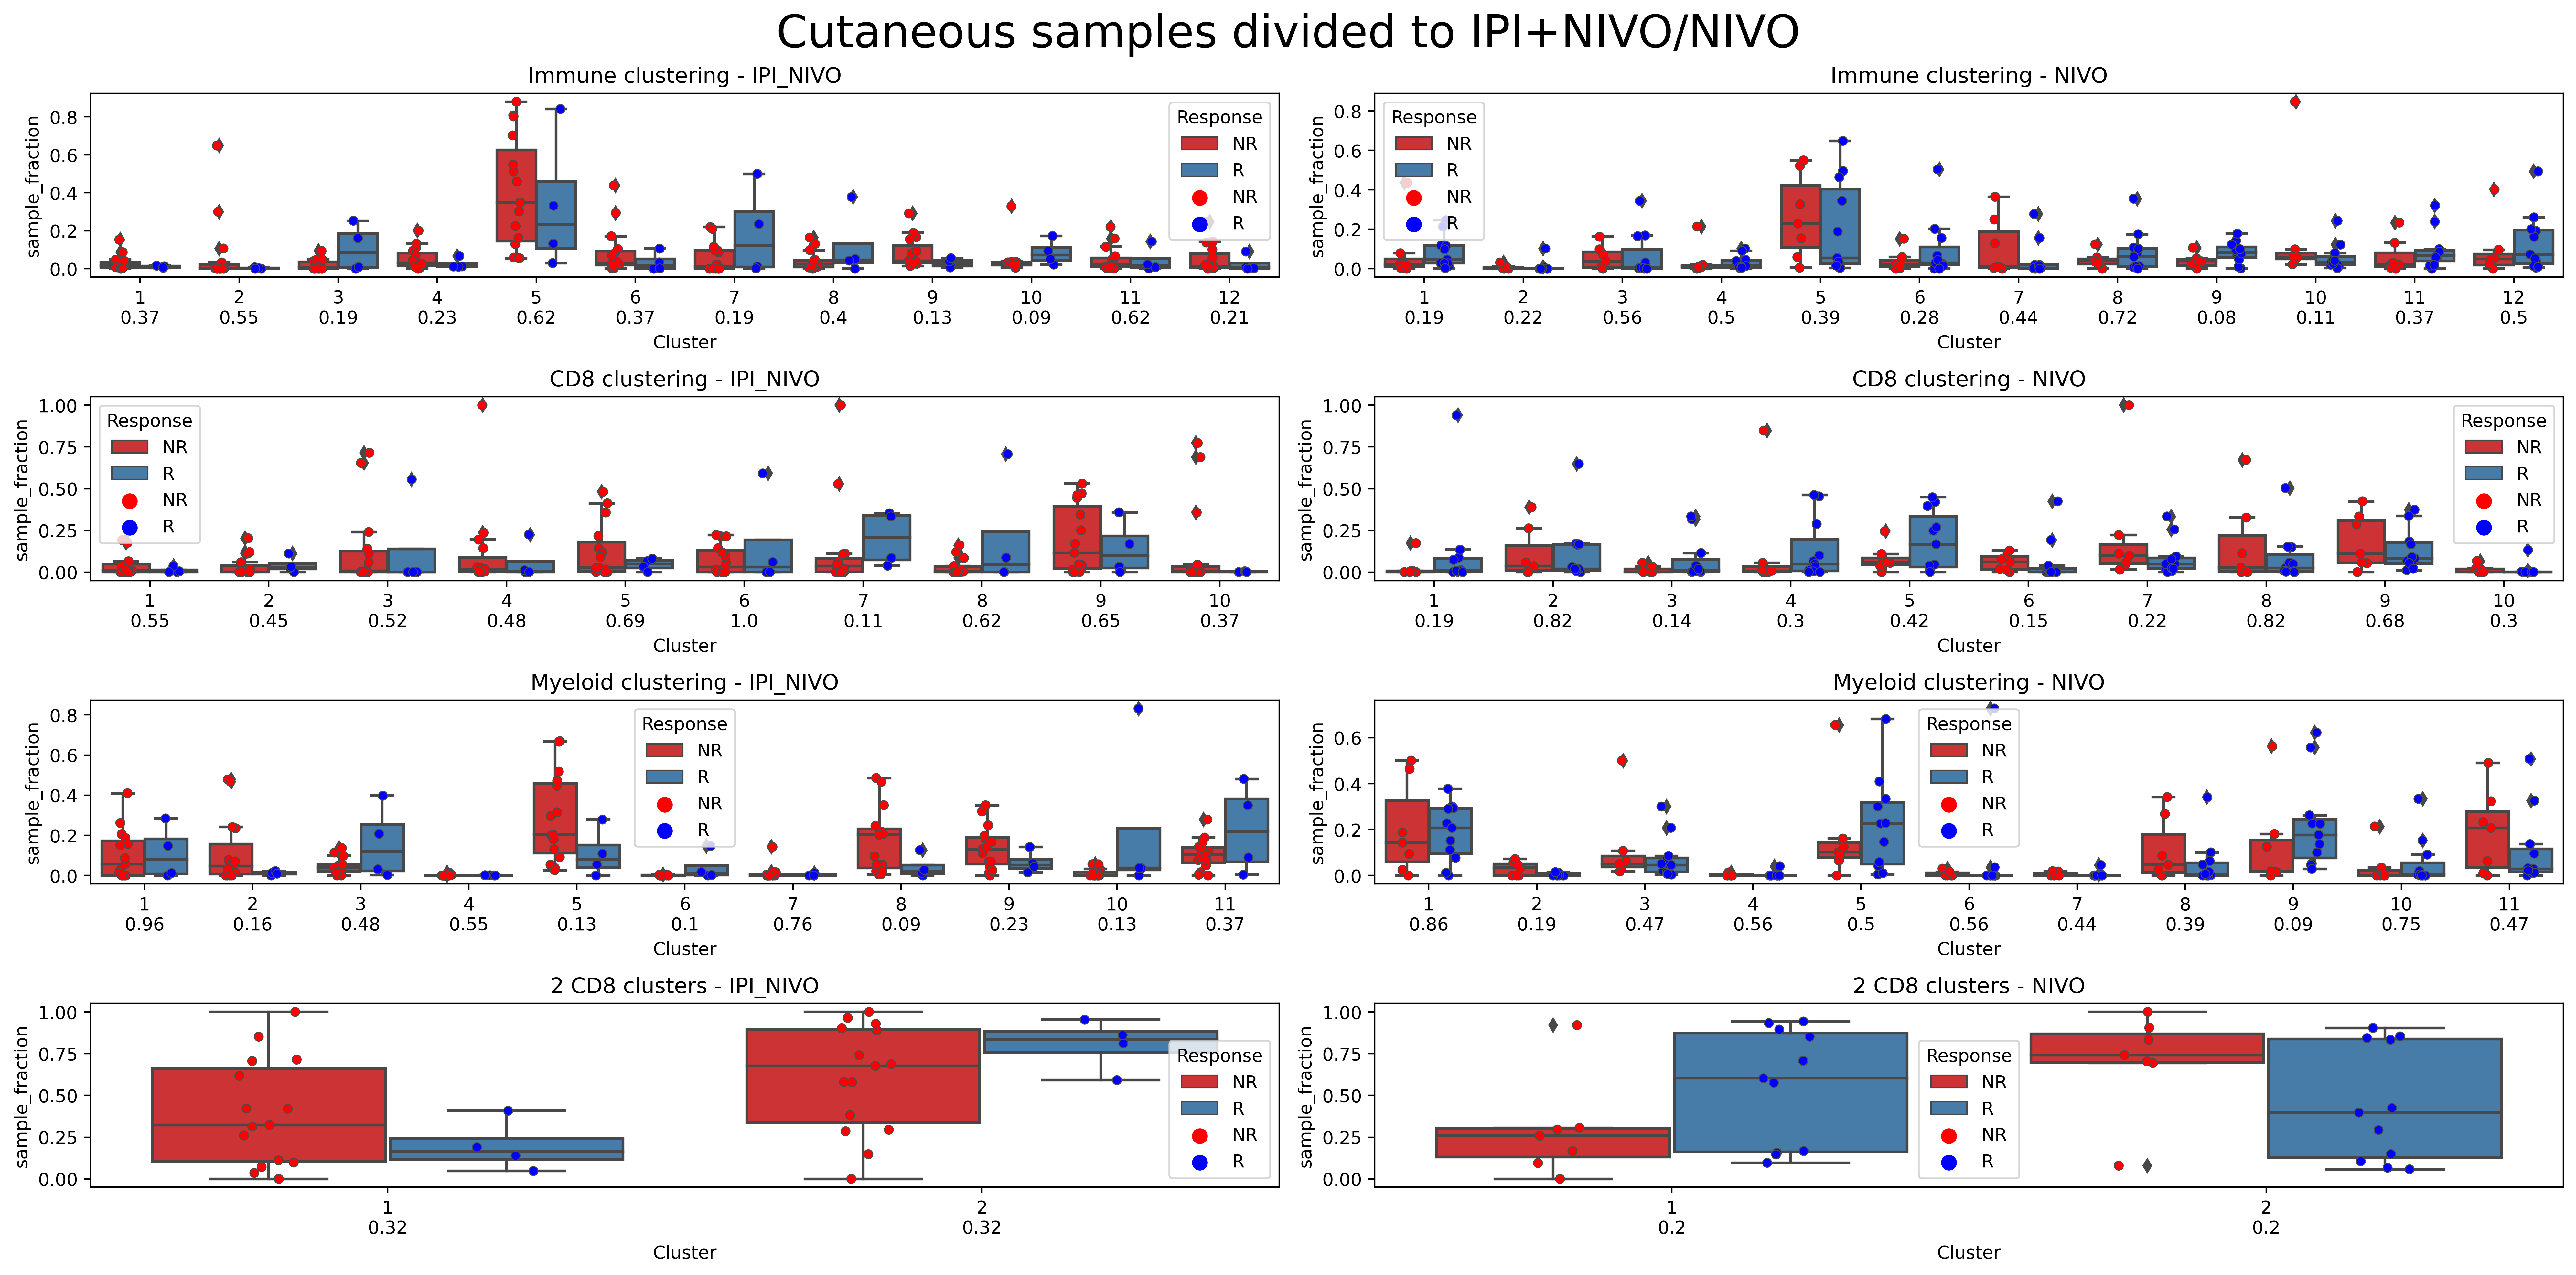

In [9]:
(fig,axes) = plt.subplots(4, 2, figsize=(20, 10))
axes = axes.ravel()

#### immune
for idx, (group_name, group_df) in enumerate(all_groups.items()):
    print(group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR')
    group_fractions = immune_cluster_fraction[immune_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title='Immune clustering - '+group_name);
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = CD8_cluster_fraction[CD8_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx+2], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title='CD8 clustering - '+group_name);
    sns.stripplot(ax=axes[idx+2],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = myeloid_cluster_fraction[myeloid_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx+4], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title='Myeloid clustering - '+group_name);
    sns.stripplot(ax=axes[idx+4],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});


for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = exh_mem_CD8_cluster_fraction[exh_mem_CD8_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[6+idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title='2 CD8 clusters - '+group_name);
    sns.stripplot(ax=axes[6+idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    

fig.suptitle('Cutaneous samples divided to IPI+NIVO/NIVO', fontsize=25);


plt.tight_layout(pad=1)

Immune:
1.	B-cells,    2.	CD8 T cells,    3.	exhausted T-cells,    4.	NK cells,    5.	myeloids - macrophages,    6.	cytotoxic CD8 cells,    7.	Activated \ Exhausted T cells,    8.	CD4,    9.	Regulatory T cells,    10.	Cycling cells,    11.	Effector cytotoxic T cells,    12.	memory T cells

CD8:
1.	activaed/effector CD160+, 2.	exhausted CXCL13+, 3.	activated/effectro CX3CR1+NCR3+, 4.	Memeory like, 5.	effcetor/memory KLRB1+, 6.	activated/exhuasted HLA-DQA2+HAVCR2+, 7.	Cycling, 8.	exhausted, 9.	effcetor KLRG1+, 10.	Inhibitory HSP+ HLA-G+ LILRB1+

Myeloid:
1.	Mac(6)- CD209+ PLTP+CCL18+, 2.	mix of Mac + neutrophils, 3.	Mac (8)- C3+ CXCL9+, 4.	TAMs-SIGLEC10+SIGLEC11+, 5.	Mono, 6.	Mac(7) MARCO+RBP4+ and  DC3- FSCN1+LY75+, 7.	neutrophils CXCR1+CXCR2+, 8.	Cycling macrophages, 9.	cDC2- CD1C+FCER1A+, 10.	Mac- IFN-i+, 11.	Activated Mac- CXCL9+CXCL10+

CD8 2 clusters:

1. (CD8_G):  memory.
2. (CD8_B):  exhaustion

### 3.2.  Cutaneous samples divided to IPI+NIVO/NIVO, Pre/Post

In [44]:
# all_groups = {'IPI_NIVO_pre':IPI_NIVO_Pre_cutaneous_melanoma_clinical_data,
#  'IPI_NIVO_post':IPI_NIVO_Post_cutaneous_melanoma_clinical_data,
#  'NIVO_pre':NIVO_Pre_cutaneous_melanoma_clinical_data,
#  'NIVO_post':NIVO_Post_cutaneous_melanoma_clinical_data}

all_groups = {'IPI_NIVO':IPI_NIVO_cutaneous_melanoma_clinical_data,
             'NIVO':NIVO_cutaneous_melanoma_clinical_data}


In [35]:
(fig,axes) = plt.subplots(8, 2, figsize=(20, 20))
axes = axes.ravel()

#### immune
for idx, (group_name, group_df) in enumerate(all_groups.items()):
    print(group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR')
    group_fractions = immune_cluster_fraction[immune_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title='Immune clustering - '+group_name);
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = CD8_cluster_fraction[CD8_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx+4], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title='CD8 clustering - '+group_name);
    sns.stripplot(ax=axes[idx+4],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = myeloid_cluster_fraction[myeloid_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx+8], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title='Myeloid clustering - '+group_name);
    sns.stripplot(ax=axes[idx+8],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});


for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = exh_mem_CD8_cluster_fraction[exh_mem_CD8_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[12+idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title='2 CD8 clusters - '+group_name);
    sns.stripplot(ax=axes[12+idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    

fig.suptitle('Cutaneous samples divided to IPI+NIVO/NIVO, Pre/Post', fontsize=25);


plt.tight_layout(pad=1)

IPI_NIVO_pre     2-R 4-NR
IPI_NIVO_post     2-R 11-NR
NIVO_pre     6-R 1-NR
NIVO_post     5-R 6-NR


### pre and post combined
#### Immune clustering:

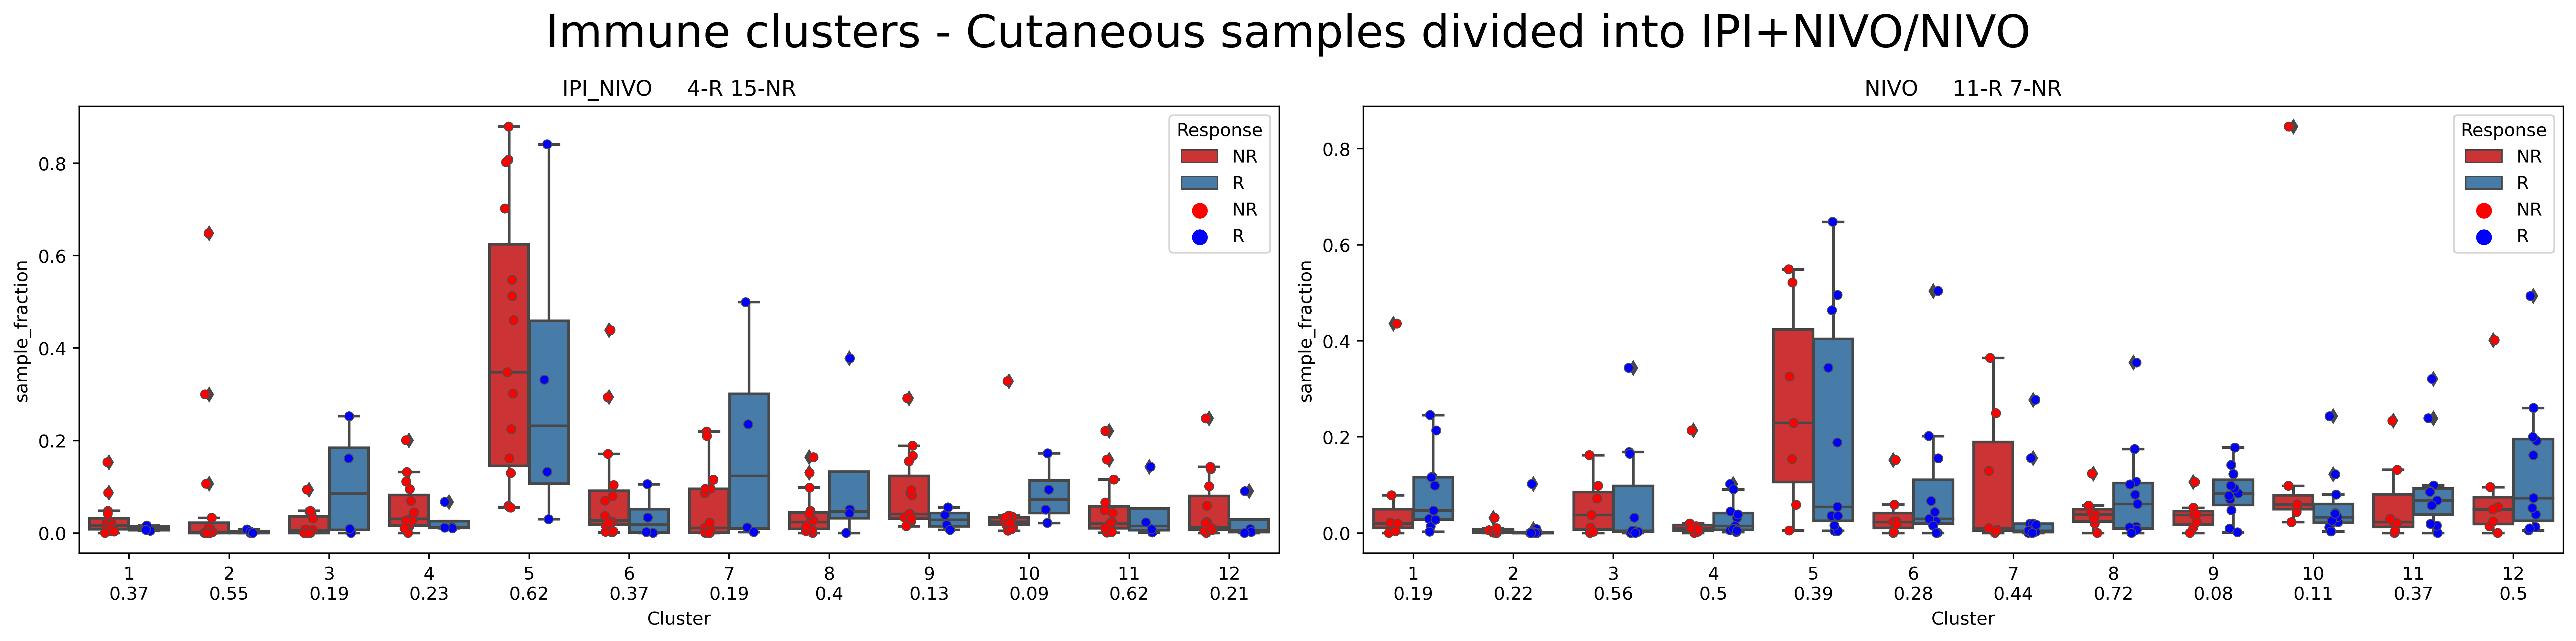

In [52]:
(fig,axes) = plt.subplots(int(len(all_groups)/2), 2, figsize=(20, int(5*len(all_groups)/2)))
axes = axes.ravel()
pre_post = '' if len(all_groups)==2 else ', Pre/Post'

for idx, (group_name, group_df) in enumerate(all_groups.items()):
#     print(f'{group_name}:\n{group_df["response"].value_counts()}')
    group_fractions = immune_cluster_fraction[immune_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title=group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    
fig.suptitle('Immune clusters - Cutaneous samples divided into IPI+NIVO/NIVO'+pre_post, fontsize=25);
plt.tight_layout(pad=1)


1	B-cells

2	CD8 T cells

3	exhausted T-cells

4	NK cells

5	myeloids - macrophages

6	cytotoxic CD8 cells

7	Activated \ Exhausted T cells

8	CD4

9	Regulatory T cells

10	Cycling cells

11	Effector cytotoxic T cells

12	memory T cells


#### CD8 clustering:

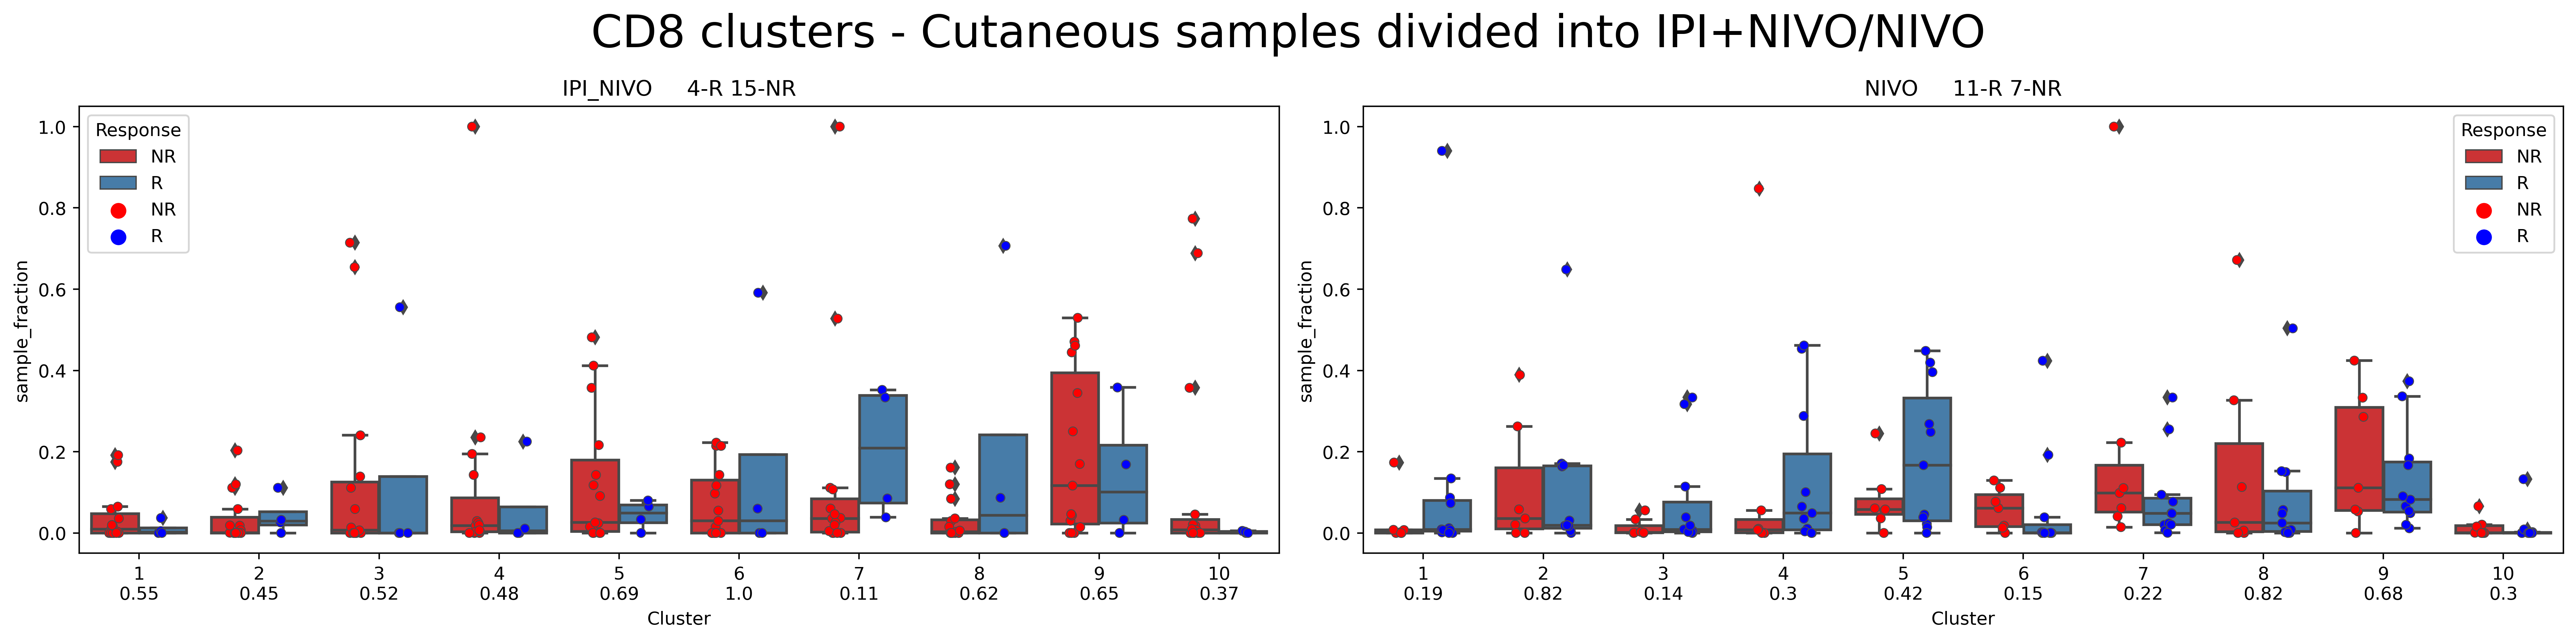

In [53]:
(fig,axes) = plt.subplots(int(len(all_groups)/2), 2, figsize=(20, int(5*len(all_groups)/2)))
axes = axes.ravel()
pre_post = '' if len(all_groups)==2 else ', Pre/Post'

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = CD8_cluster_fraction[CD8_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title=group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    
fig.suptitle('CD8 clusters - Cutaneous samples divided into IPI+NIVO/NIVO'+pre_post, fontsize=25);
plt.tight_layout(pad=1)

1	activaed/effector CD160+

2	exhausted CXCL13+ 

3	activated/effectro CX3CR1+NCR3+

4	Memeory like

5	effcetor/memory KLRB1+

6	activated/exhuasted HLA-DQA2+HAVCR2+

7	Cycling

8	exhausted

9	effcetor KLRG1+

10	Inhibitory HSP+ HLA-G+ LILRB1+

#### Myeloid clustering:

In [54]:
(fig,axes) = plt.subplots(int(len(all_groups)/2), 2, figsize=(20, int(5*len(all_groups)/2)))
axes = axes.ravel()
pre_post = '' if len(all_groups)==2 else ', Pre/Post'

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = myeloid_cluster_fraction[myeloid_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title=group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    
fig.suptitle('Myeloid clusters - Cutaneous samples divided into IPI+NIVO/NIVO'+pre_post, fontsize=25);
plt.tight_layout(pad=1)

1	Mac(6)- CD209+ PLTP+CCL18+

2	mix of Mac + neutrophils

3	Mac (8)- C3+ CXCL9+

4	TAMs-SIGLEC10+SIGLEC11+

5	Mono

6	Mac(7) MARCO+RBP4+ and  DC3- FSCN1+LY75+

7	neutrophils CXCR1+CXCR2+

8	Cycling macrophages

9	cDC2- CD1C+FCER1A+

10	Mac- IFN-i+

11	Activated Mac- CXCL9+CXCL10+


#### Exhausted and Memory CD8 clusters:

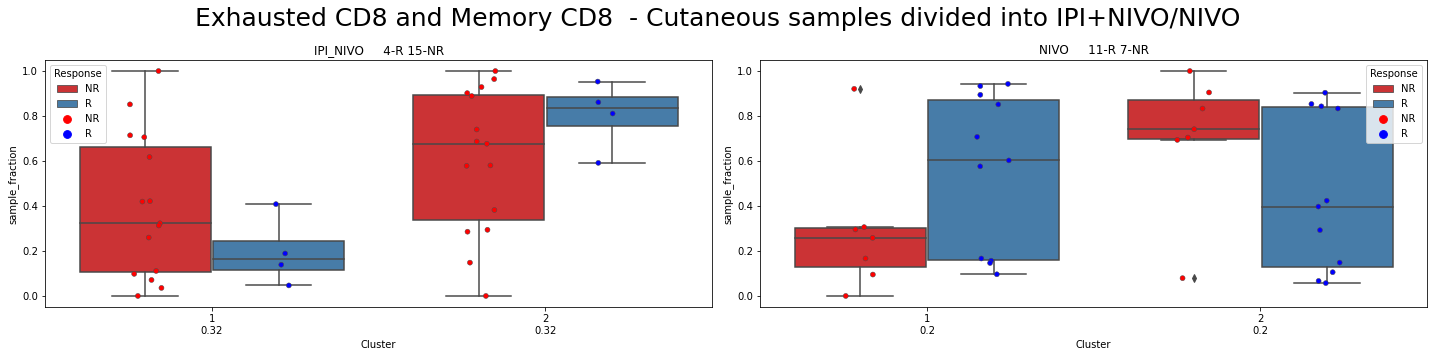

In [40]:
(fig,axes) = plt.subplots(int(len(all_groups)/2), 2, figsize=(20, int(5*len(all_groups)/2)))
axes = axes.ravel()
pre_post = '' if len(all_groups)==2 else ', Pre/Post'

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = exh_mem_CD8_cluster_fraction[exh_mem_CD8_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title=group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    
fig.suptitle('Exhausted CD8 and Memory CD8  - Cutaneous samples divided into IPI+NIVO/NIVO'+pre_post, fontsize=25);
plt.tight_layout(pad=1)

cluster1 (CD8_G):  memory

cluster2 (CD8_B):  exhaustion

## 4. Conduct a robust test of differential expression by discovering and cross validation (3)


In [ ]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [34]:
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)

In [ ]:
immune_cohort = cohort.filter_cells_by_property('is_immune', True)

In [ ]:
# DROPLET_R_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/integrated_cohort_4.11.21/response_immune_markers.xlsx'
# DROPLET_NR_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/integrated_cohort_4.11.21/non_response_immune_markers.xlsx'
# DROPLET_R_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/cohort_26.6.21/response_immune_markers.xlsx'
# DROPLET_NR_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/cohort_26.6.21/non_response_immune_markers.xlsx'

In [35]:
# melanoma_clinical_data = get_constant_cohort(CLINICAL_TABLE_NUM) #
melanoma_clinical_data = get_clinical_data(71, ICI=True)# after_biopsy='ICI')
melanoma_clinical_data = melanoma_clinical_data#.set_index('Patient id', drop=True)
melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['response']!='not in use for now']
print(f'Num of samples in table is {len(melanoma_clinical_data)}')
# display(melanoma_clinical_data.head(20))
melanoma_clinical_data['response'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv
Num of samples in table is 51


NR    31
R     20
Name: response, dtype: int64

In [36]:
train_r = melanoma_clinical_data[melanoma_clinical_data['response']=='R'].sample(14)
train_nr = melanoma_clinical_data[melanoma_clinical_data['response']=='NR'].sample(24)
test_r = melanoma_clinical_data[melanoma_clinical_data['response']=='R'][~melanoma_clinical_data[melanoma_clinical_data['response']=='R']['Patient id'].isin(train_r['Patient id'])]
test_nr = melanoma_clinical_data[melanoma_clinical_data['response']=='NR'][~melanoma_clinical_data[melanoma_clinical_data['response']=='NR']['Patient id'].isin(train_nr['Patient id'])]

In [37]:
def split_to_train_and_test(melanoma_clinical_data, n_train_R=14, n_train_NR=24):
    train_r = melanoma_clinical_data[melanoma_clinical_data['response']=='R'].sample(n_train_R)
    train_nr = melanoma_clinical_data[melanoma_clinical_data['response']=='NR'].sample(n_train_NR)
    test_r = melanoma_clinical_data[melanoma_clinical_data['response']=='R'][~melanoma_clinical_data[melanoma_clinical_data['response']=='R']['Patient id'].isin(train_r['Patient id'])]
    test_nr = melanoma_clinical_data[melanoma_clinical_data['response']=='NR'][~melanoma_clinical_data[melanoma_clinical_data['response']=='NR']['Patient id'].isin(train_nr['Patient id'])]
    return train_r, train_nr, test_r, test_nr

def find_overlap_markers(subcohort, train_r, train_nr, test_r, test_nr):
    # cohort of sets
    train_r_cohort = subcohort[[sample in train_r['Patient id'].tolist() for sample in subcohort.samples]]
    train_nr_cohort = subcohort[[sample in train_nr['Patient id'].tolist() for sample in subcohort.samples]]
    test_r_cohort = subcohort[[sample in test_r['Patient id'].tolist() for sample in subcohort.samples]]
    test_nr_cohort = subcohort[[sample in test_nr['Patient id'].tolist() for sample in subcohort.samples]]

    # differential expression analysis - train set
    train_r_markers = find_satisfying_list_of_markers_in_cluster(train_r_cohort, train_nr_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                                  min_pct=0.1, min_diff_pct=0.1, min_mean_exp=1, min_markers=30)
    train_nr_markers = find_satisfying_list_of_markers_in_cluster(train_nr_cohort, train_r_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                                  min_pct=0.1, min_diff_pct=0.1, min_mean_exp=1, min_markers=30)
    # differential expression analysis - test set
    test_r_markers = find_satisfying_list_of_markers_in_cluster(test_r_cohort, test_nr_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                                  min_pct=0.1, min_diff_pct=0.1, min_mean_exp=1, min_markers=30)
    test_nr_markers = find_satisfying_list_of_markers_in_cluster(test_nr_cohort, test_r_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                                  min_pct=0.1, min_diff_pct=0.1, min_mean_exp=1, min_markers=30)

    # build overlap table
    overlap_markers_counting_table = pd.DataFrame(columns=['top', '# R markers in overlap', '# NR markers in overlap', '# R markers in train', 
                                                           '# NR markers in train', '# R markers in test', '# NR markers in test', 'overlap R markers', 'overlap NR markers'])
    for n_of_markers in [20, 50, 100, 200]:
        R_overlap = intersection_of_lists(train_r_markers['gene names'].iloc[:n_of_markers], test_r_markers['gene names'].iloc[:n_of_markers])
        NR_overlap = intersection_of_lists(train_nr_markers['gene names'].iloc[:n_of_markers], test_nr_markers['gene names'].iloc[:n_of_markers])

        overlap_markers_counting_table = overlap_markers_counting_table.append(pd.DataFrame([[n_of_markers, len(R_overlap), len(NR_overlap),
                                                                                              min(len(train_r_markers), n_of_markers), min(len(train_nr_markers), n_of_markers), 
                                                                                              min(len(test_r_markers), n_of_markers), min(len(test_nr_markers), n_of_markers),
                                                                                             R_overlap, NR_overlap]], columns=overlap_markers_counting_table.columns))
    overlap_markers_counting_table = overlap_markers_counting_table.reset_index(drop=True)
    
    return overlap_markers_counting_table, train_r_markers, train_nr_markers, test_r_markers, test_nr_markers

#### split clinical table to test and train:

In [38]:
train_r, train_nr, test_r, test_nr = split_to_train_and_test(melanoma_clinical_data)

In [39]:
# melanoma_clinical_data.iloc[:36]['response'].value_counts()
print(f'train_r: {len(train_r)} samples')
print(f'train_nr: {len(train_nr)} samples')
print(f'test_r: {len(test_r)} samples')
print(f'test_nr: {len(test_nr)} samples')

train_r: 14 samples
train_nr: 24 samples
test_r: 6 samples
test_nr: 7 samples


#### see overlap of markers in immune cells:

In [40]:
overlap_immune_markers_counting_table, train_r_immune_markers, train_nr_immune_markers, test_r_immune_markers, test_nr_immune_markers = find_overlap_markers(immune_cohort, train_r, train_nr, test_r, test_nr)

Have not found more than 30 markers, lower demands:
Round 1
min_diff_pct: 0.05
min_pct: 0.05
min_mean_exp: 0.5
Have not found more than 30 markers, lower demands:
Round 2
min_diff_pct: 0.025
min_pct: 0.025
min_mean_exp: 0.25
Have not found more than 30 markers, lower demands:
Round 1
min_diff_pct: 0.05
min_pct: 0.05
min_mean_exp: 0.5
Have not found more than 30 markers, lower demands:
Round 1
min_diff_pct: 0.05
min_pct: 0.05
min_mean_exp: 0.5


In [41]:
overlap_immune_markers_counting_table

top # R markers in overlap # NR markers in overlap # R markers in train  \
0   20                      1                       0                    1   
1   50                      1                       2                    1   
2  100                      1                       2                    1   
3  200                      1                       2                    1   

  # NR markers in train # R markers in test # NR markers in test  \
0                    20                  20                   20   
1                    50                  50                   50   
2                    53                 100                   51   
3                    53                 107                   51   

  overlap R markers overlap NR markers  
0          [RPS4Y1]                 []  
1          [RPS4Y1]        [GZMH, ID2]  
2          [RPS4Y1]        [GZMH, ID2]  
3          [RPS4Y1]        [GZMH, ID2]

#### see overlap of markers in tumor cells:

In [42]:
overlap_tumor_markers_counting_table, train_r_tumor_markers, train_nr_tumor_markers, test_r_tumor_markers, test_nr_tumor_markers = find_overlap_markers(tumor_cohort, train_r, train_nr, test_r, test_nr)

Have not found more than 30 markers, lower demands:
Round 1
min_diff_pct: 0.05
min_pct: 0.05
min_mean_exp: 0.5
Have not found more than 30 markers, lower demands:
Round 1
min_diff_pct: 0.05
min_pct: 0.05
min_mean_exp: 0.5


In [43]:
overlap_tumor_markers_counting_table

top # R markers in overlap # NR markers in overlap # R markers in train  \
0   20                      0                       0                   20   
1   50                      0                       4                   50   
2  100                      5                       7                  100   
3  200                      6                       7                  103   

  # NR markers in train # R markers in test # NR markers in test  \
0                    20                  20                   20   
1                    50                  50                   50   
2                   100                  98                   55   
3                   102                  98                   55   

                          overlap R markers  \
0                                        []   
1                                        []   
2       [LGALS1, RBX1, SPARC, MT2A, POLR2F]   
3  [DBI, LGALS1, RBX1, SPARC, MT2A, POLR2F]   

                                  overlap NR markers  
0                                                 []  
1                    [ZC3H13, METTL9, RAB38, GPR143]  
2  [DNPH1, ZC3H13, RAB38, CCT3, UFC1, GPR143, MET...  
3  [DNPH1, ZC3H13, RAB38, CCT3, UFC1, GPR143, MET...

#### Conduct Wilcoxon signed-rank test on mean expression of top 20 markers of train:

In [5]:
def statistical_test_1(subcohort, train_markers, train_df, test_df):
    markers_indices = [subcohort.features.index(feature) for feature in train_markers.iloc[:20]['features']]

    train_cohort = subcohort[[sample in train_df['Patient id'].tolist() for sample in subcohort.samples]]
    test_cohort = subcohort[[sample in test_df['Patient id'].tolist() for sample in subcohort.samples]]
#     print(train_cohort.counts[:, markers_indices].mean(axis=0), test_cohort.counts[:, markers_indices].mean(axis=0))
    return scipy.stats.wilcoxon(train_cohort.counts[:, markers_indices].mean(axis=0), test_cohort.counts[:, markers_indices].mean(axis=0))[1]

In [45]:
print(f'immune markers of responder train vs test:\tpval: {statistical_test_1(immune_cohort, train_r_immune_markers, train_r, test_r)}')
print(f'immune markers of non-responder train vs test:\tpval: {statistical_test_1(immune_cohort, train_nr_immune_markers, train_nr, test_nr)}')
print(f'tumor markers of responder train vs test:\tpval: {statistical_test_1(tumor_cohort, train_r_tumor_markers, train_r, test_r)}')
print(f'tumor markers of non-responder train vs test:\tpval: {statistical_test_1(tumor_cohort, train_nr_tumor_markers, train_nr, test_nr)}')

immune markers of responder train vs test:	pval: 1.0
immune markers of non-responder train vs test:	pval: 0.21616744995117188
tumor markers of responder train vs test:	pval: 0.0004825592041015625
tumor markers of non-responder train vs test:	pval: 0.01923370361328125


#### Conduct ranksum test on mean expression of top 20 markers of train:

In [6]:
def statistical_test_2(subcohort, train_markers, train_df, test_df):
    markers_indices = [subcohort.features.index(feature) for feature in train_markers.iloc[:20]['features']]

    train_scores = [subcohort.counts[[sample==curr_sample for sample in subcohort.samples],:][:, markers_indices].mean() for curr_sample in train_df['Patient id'].tolist()]
    test_scores = [subcohort.counts[[sample==curr_sample for sample in subcohort.samples],:][:, markers_indices].mean() for curr_sample in test_df['Patient id'].tolist()]
    
    return ranksums(train_scores, test_scores)[1]


In [47]:
print(f'immune markers of responder train vs test:\tpval: {statistical_test_2(immune_cohort, train_r_immune_markers, train_r, test_r)}')
print(f'immune markers of non-responder train vs test:\tpval: {statistical_test_2(immune_cohort, train_nr_immune_markers, train_nr, test_nr)}')
print(f'tumor markers of responder train vs test:\tpval: {statistical_test_2(tumor_cohort, train_r_tumor_markers, train_r, test_r)}')
print(f'tumor markers of non-responder train vs test:\tpval: {statistical_test_2(tumor_cohort, train_nr_tumor_markers, train_nr, test_nr)}')

immune markers of responder train vs test:	pval: 0.32229959587191925
immune markers of non-responder train vs test:	pval: 0.6366016325636008
tumor markers of responder train vs test:	pval: 0.013347575926843162
tumor markers of non-responder train vs test:	pval: 0.3447042220069576


## 5. identify the % of organ cells in each biopsy (5)


In [6]:
# melanoma_clinical_data = get_constant_cohort(CLINICAL_TABLE_NUM) #
melanoma_clinical_data = get_clinical_data(71, additional_features=['Biopsy site'])# after_biopsy='ICI')
melanoma_clinical_data = melanoma_clinical_data#.set_index('Patient id', drop=True)
# melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['response']!='not in use for now']
print(f'Num of samples in table is {len(melanoma_clinical_data)}')
# display(melanoma_clinical_data.head(20))
melanoma_clinical_data['response'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv
Num of samples in table is 71


NR                    32
R                     20
not in use for now    19
Name: response, dtype: int64

In [7]:
# sort_dic(dict(Counter(melanoma_clinical_data['Biopsy site'])), descending=True, by_key=False)

In [11]:
y = melanoma_clinical_data['Biopsy site'].apply(lambda x: 'LN' if ('LN' in str(x) or 'lymph node' in str(x).lower()) else x)
y = y.apply(lambda x: 'ovary' if ('ovary' in str(x).lower()) else x)
y = y.apply(lambda x: 'Liver' if ('liver' in str(x).lower()) else x)
y = y.apply(lambda x: 'Lung' if ('lung' in str(x).lower()) else x)
y = y.apply(lambda x: 'Skin' if ('skin' in str(x).lower()) else x)
sort_dic(dict(Counter(y)), descending=True, by_key=False)

{'LN': 21,
 'Liver': 4,
 'Lung': 4,
 'Craniotomy': 4,
 'Thoracentesis': 3,
 nan: 3,
 'Endoscopy': 2,
 'Vulva (primary)': 2,
 'Peritoneal fluid': 2,
 'Right thigh (leg)': 2,
 'ovary': 2,
 'Left distal femur curettage': 1,
 'Left foot': 1,
 'Spine met (NR)': 1,
 'Small bowel met': 1,
 'Penis': 1,
 'Abdominal wall (soft tissue)': 1,
 'Right heel (bone biopsy)': 1,
 'Left popliteal fossa (back on the knee)': 1,
 'Right mesentery mass core biopsy': 1,
 'Spleen': 1,
 'Bladder (met)': 1,
 'Skin': 1,
 'Right chest core needle biopsy': 1,
 'Right inguinal lymphadenectomy': 1,
 'Frontal lobe met': 1,
 'Right breast': 1,
 'Craniotomy- right frontal lesion': 1,
 'colonoscopy': 1,
 'Left shoulder': 1,
 'Right foot': 1,
 'Paracentesis (pelvis area)': 1,
 'Leg resection': 1}

## 6. plot a histogram of the number of T-cells; Myeloids and B-cells for example across the entire cohort (6)


In [3]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [36]:
melanoma_clinical_data = get_clinical_data(n_samples=71, ICI=True).set_index('Patient id')
melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data.response.isin(['R', 'NR'])]
melanoma_clinical_data.head()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv


Melanoma type response prior to biopsy          after biopsy   ICI  \
Patient id                                                                      
M97            Cutaneous        R         nothing                   ICI  True   
M98            Cutaneous        R             ICI         other therapy  True   
M99              Mucosal       NR             ICI  other immune therapy  True   
M100           Cutaneous       NR             ICI               nothing  True   
M101               other        R         nothing                   ICI  True   

             BRAF  
Patient id         
M97         False  
M98         False  
M99         False  
M100        False  
M101        False

In [4]:
from anndata import AnnData
ann_cohort = cohort.convert_to_AnnData()
# AnnData

In [5]:
cohort_df = ann_cohort.obs.copy()

In [6]:
# B_cells_cluster_idx = 1
# IMMUNE_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'

# #######################
# immune_clustering_mapping_barcodes = pd.read_csv(IMMUNE_CLUSTERING_PATH).drop(columns=['Unnamed: 0'])
# B_cells_barcodes = [tuple(aa) for aa in immune_clustering_mapping_barcodes[immune_clustering_mapping_barcodes.Cluster==B_cells_cluster_idx][['Sample', 'Barcode']].values.tolist()]
# cohort_df['B cells cluster'] = cohort_df.apply(lambda x: (x['sample'], x['barcode']) in B_cells_barcodes, axis=1)

In [7]:
cohort_df['T cells'] = cohort_df.cell_type_list.apply(lambda x: 'T cells' in x)
cohort_df['B cells'] = cohort_df.cell_type_list.apply(lambda x: 'B cells' in x)

In [20]:
# cohort_df

#### Builds cohort_dfs of % and #:

In [8]:
proportions_cohort_df = cohort_df.groupby('sample').agg(immune=('is_immune', 'mean'), 
                                                         stromal=('is_stromal', 'mean'), 
                                                         tumor=('is_cancer', 'mean'))

amounts_cohort_df = cohort_df.groupby('sample').agg(immune=('is_immune', 'sum'), 
                                                     stromal=('is_stromal', 'sum'), 
                                                     tumor=('is_cancer', 'sum'), 
                                                     lymphoid=('is_lymphoid', 'sum'), 
                                                     myeloid=('is_myeloid', 'sum'),
                                                     T_cells=('T cells', 'sum'),
                                                     B_cells=('B cells', 'sum'))
                                                   

In [97]:
response_proportions_cohort_df = proportions_cohort_df.reset_index()
response_proportions_cohort_df = response_proportions_cohort_df[response_proportions_cohort_df['sample'].isin(melanoma_clinical_data.index.tolist())]
response_proportions_cohort_df['response'] = response_proportions_cohort_df.apply(lambda x: melanoma_clinical_data.loc[x['sample']].response, axis=1)
response_proportions_cohort_df = response_proportions_cohort_df.melt(id_vars=["sample", "response"], var_name=["cell_type"], value_name="%")
# response_proportions_cohort_df.head()

response_amounts_cohort_df = amounts_cohort_df.reset_index()
response_amounts_cohort_df = response_amounts_cohort_df[response_amounts_cohort_df['sample'].isin(melanoma_clinical_data.index.tolist())]
response_amounts_cohort_df['response'] = response_amounts_cohort_df.apply(lambda x: melanoma_clinical_data.loc[x['sample']].response, axis=1)
response_amounts_cohort_df = response_amounts_cohort_df.melt(id_vars=["sample", "response"], var_name=["cell_type"], value_name="#")
# response_amounts_cohort_df.head()

#### % of cell-type in sample distribution:

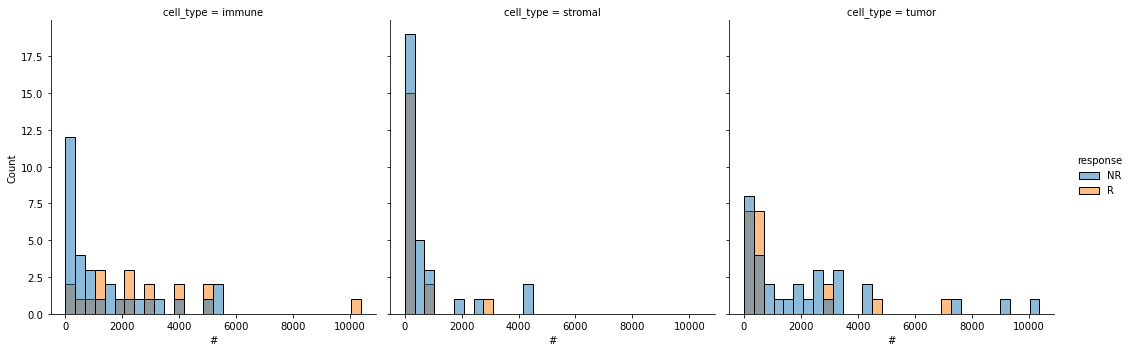

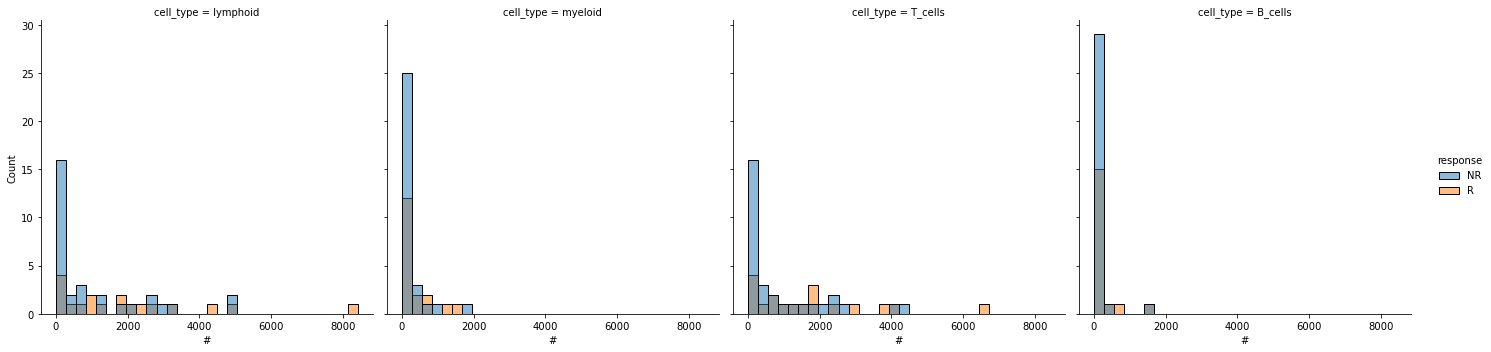

In [99]:
partly_response_amounts_cohort_df = response_amounts_cohort_df[response_amounts_cohort_df['cell_type'].isin(['immune', 'tumor', 'stromal'])]
sns.displot(data=partly_response_amounts_cohort_df, x='#', hue='response', common_norm=False, bins=30, col='cell_type');

partly_response_amounts_cohort_df = response_amounts_cohort_df[~response_amounts_cohort_df['cell_type'].isin(['immune', 'tumor', 'stromal'])]
sns.displot(data=partly_response_amounts_cohort_df, x='#', hue='response', common_norm=False, bins=30, col='cell_type');

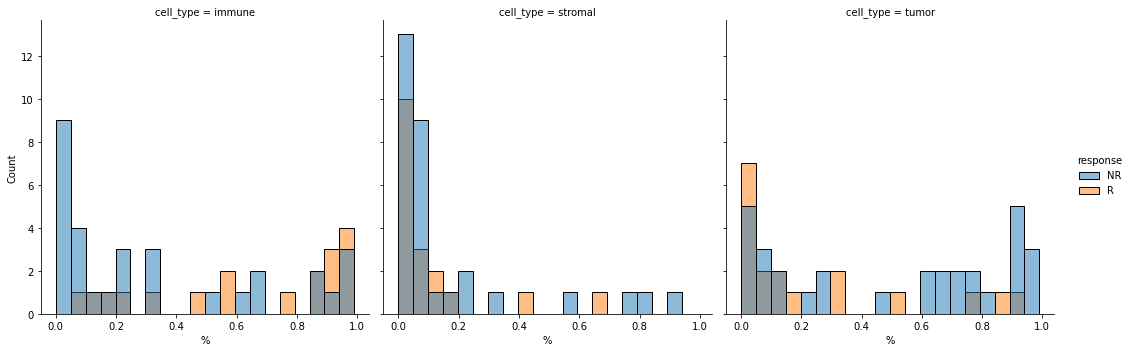

In [87]:
sns.displot(data=response_proportions_cohort_df, x='%', hue='response', common_norm=False, bins=20, col='cell_type');

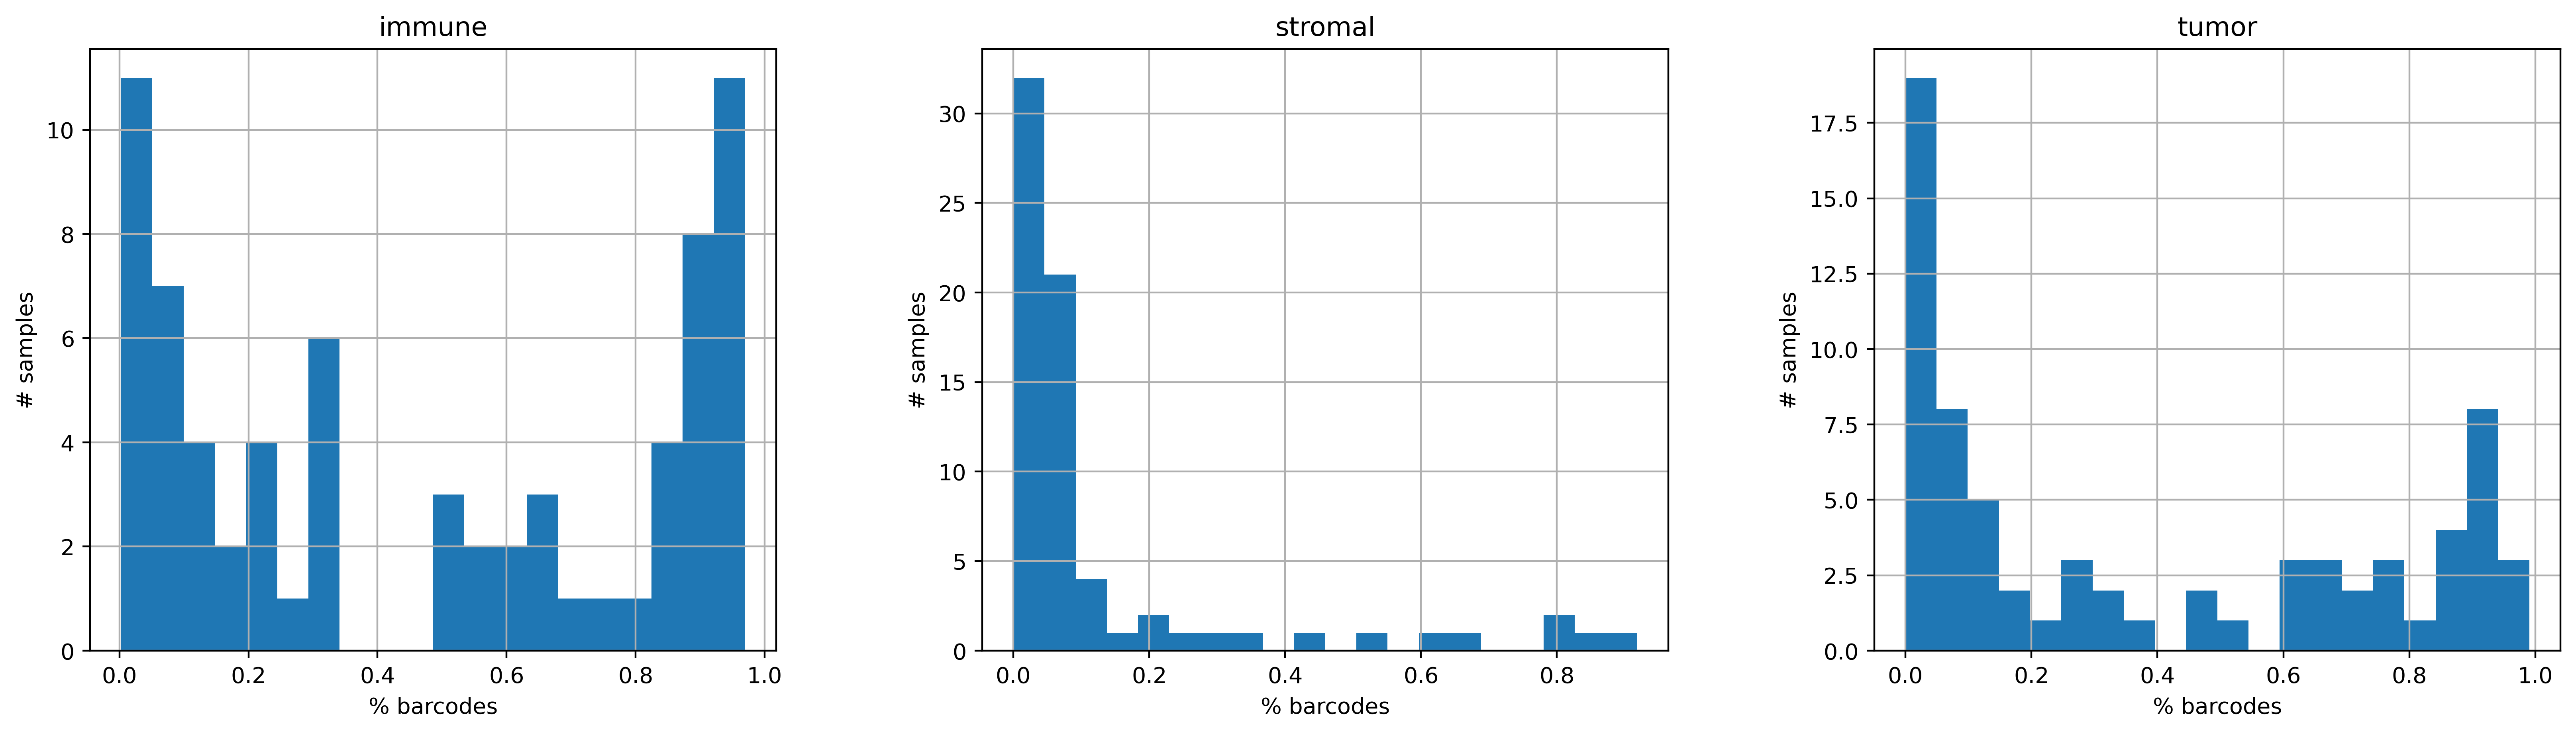

In [9]:
(fig,axes) = plt.subplots(1,3, figsize=(20, 5))
axes = axes.ravel()

for idx, col in enumerate(proportions_cohort_df.columns):        
    proportions_cohort_df.hist(column = col, bins = 20, ax=axes[idx])
    axes[idx].set(xlabel="% barcodes");
    axes[idx].set(ylabel="# samples");



#### # of cell-type in sample distribution:

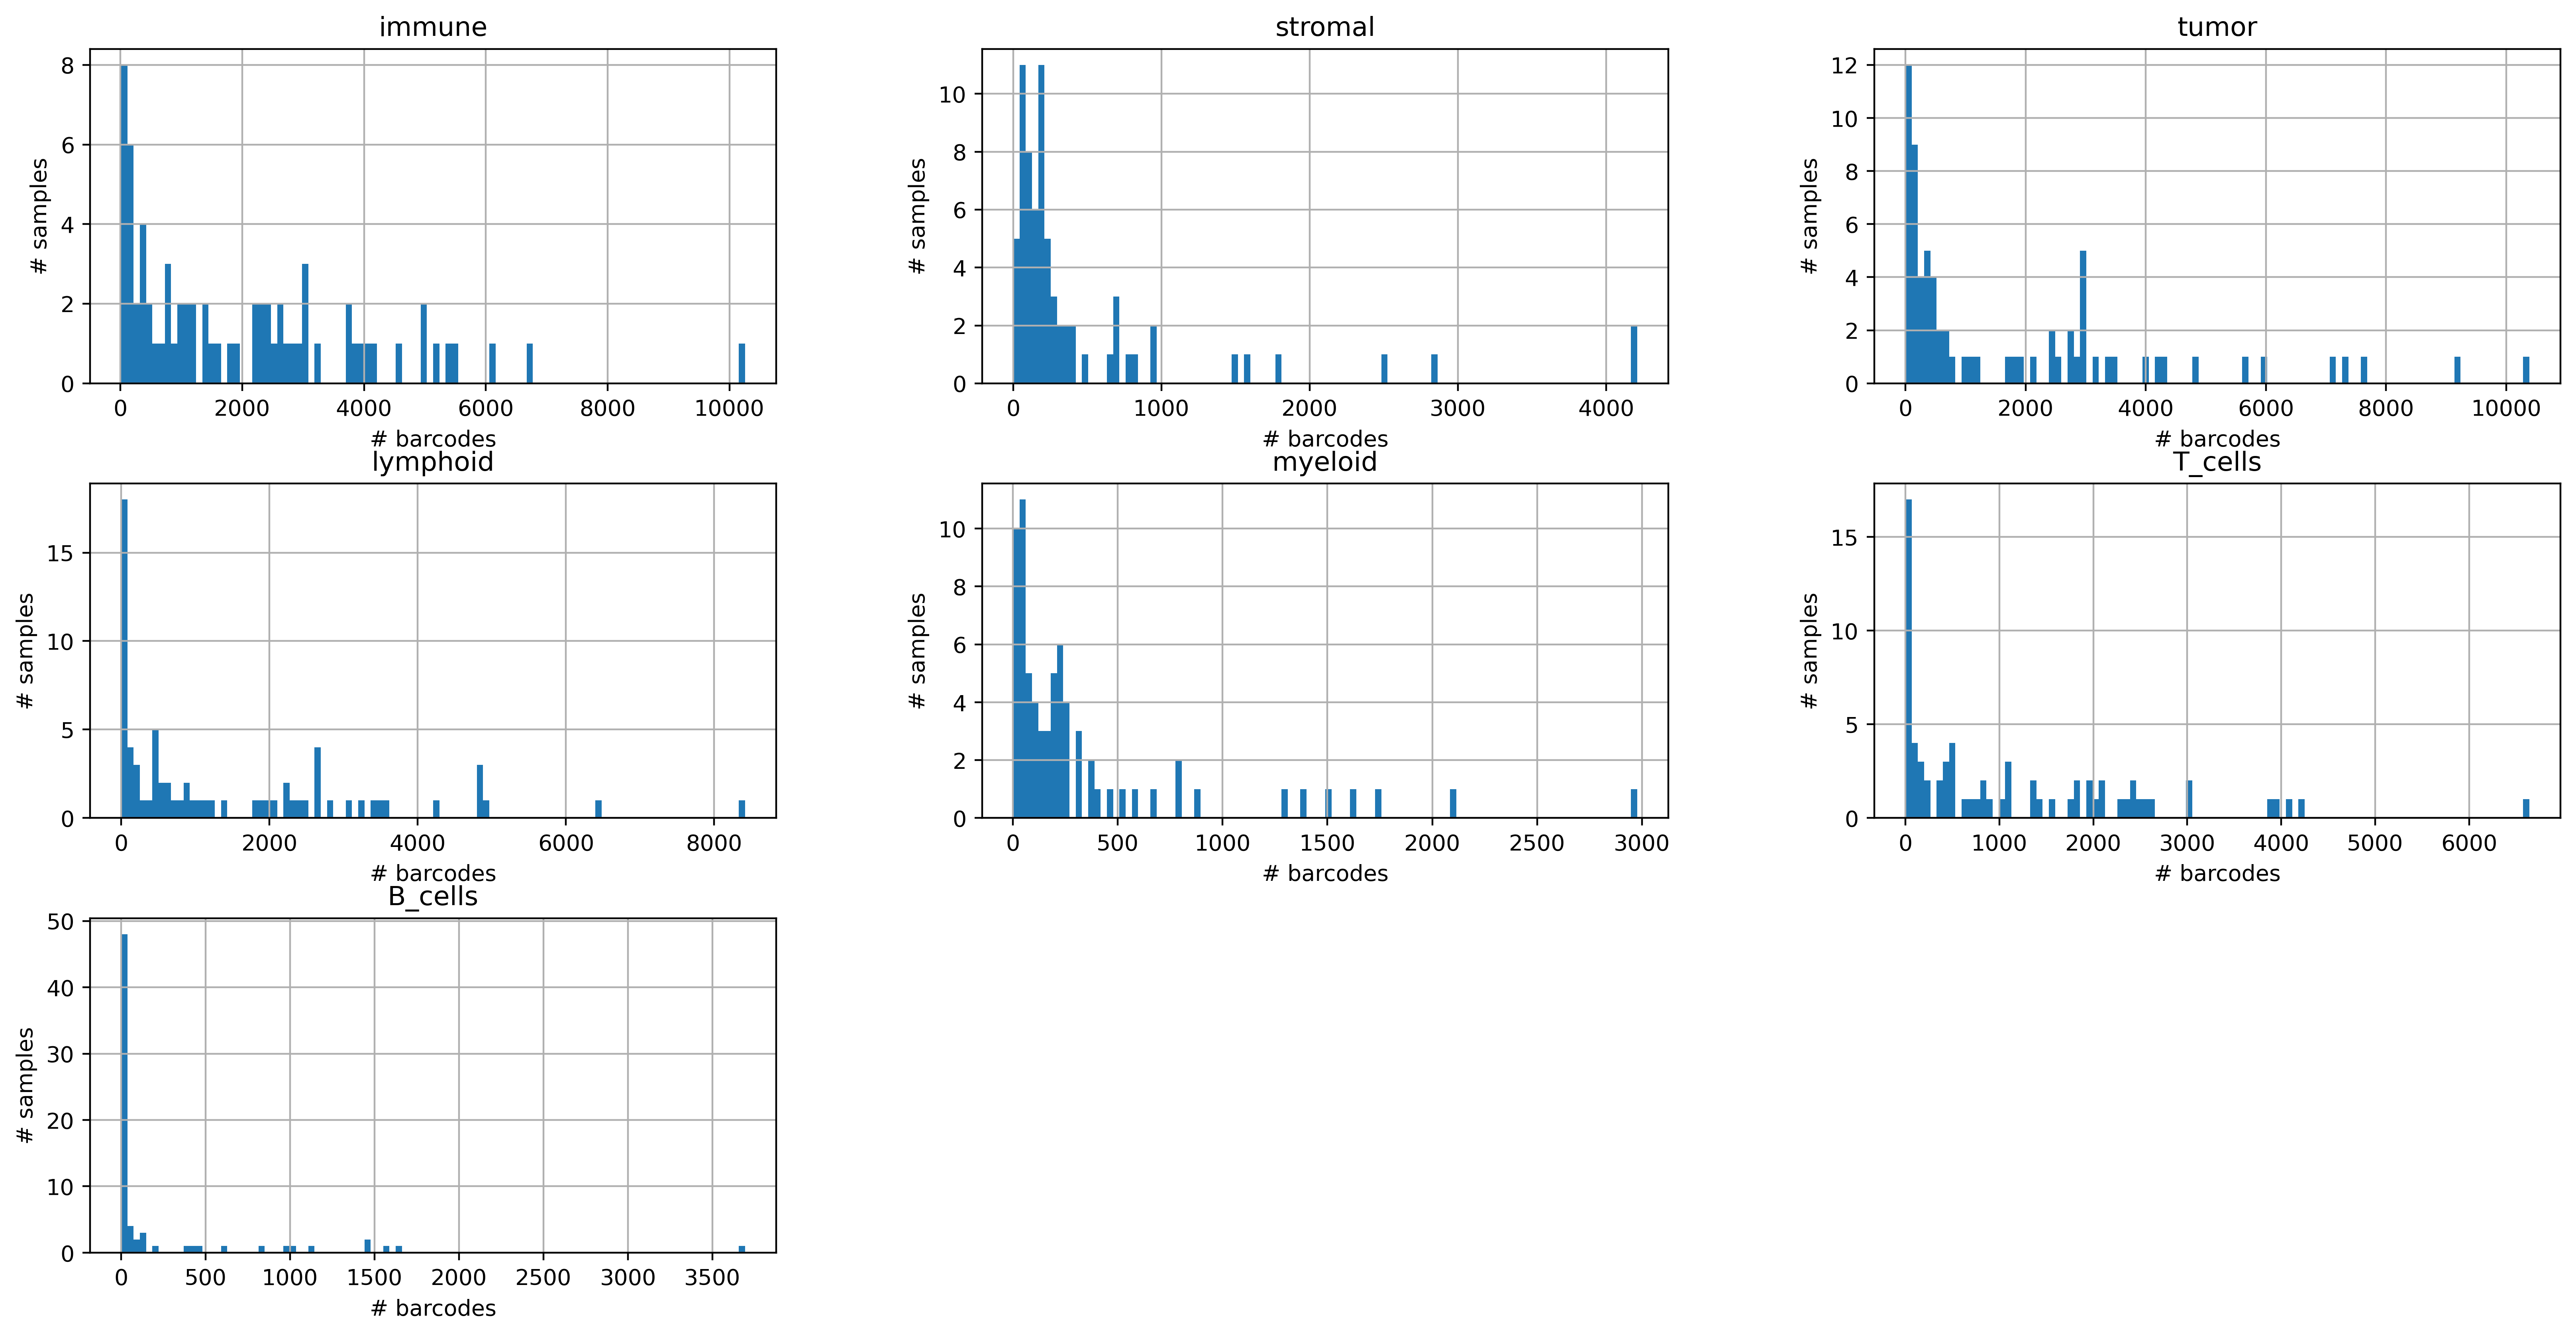

In [10]:
(fig,axes) = plt.subplots(3, 3, figsize=(20, 10))
axes = axes.ravel()

for idx, col in enumerate(amounts_cohort_df.columns):
    amounts_cohort_df.hist(column = col, bins = 100, ax=axes[idx])
    axes[idx].set(ylabel="# samples");
    axes[idx].set(xlabel="# barcodes");


    
if len(amounts_cohort_df.columns)%3>0:
    for i in range(3-len(amounts_cohort_df.columns)%3, 0, -1):
        axes[-i].remove();


#### DFs

In [1]:
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', 10)

# d1 = amounts_cohort_df.copy()
# d1.columns = '# ' + d1.columns
# d2 = proportions_cohort_df.copy()
# d2.columns = '% ' + d2.columns
# pd.concat([d2, d1], axis=1,join='inner')

In [2]:
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', 10)
# amounts_cohort_df

In [4]:
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', None)
# proportions_cohort_df#.sort_values('immune')

In [44]:
# proportions_cohort_df[proportions_cohort_df.immune<0.05]

## 7. Comparing responder/non-responder immune markers with smartseq2 study (7)


#### Part 1: use the markers of integrated data for comparison:

In [7]:
SMARTSEQ_MARKERS_PATH = r'/storage/md_keren/shitay/Data/smart_seq/tables/Discriminative genes in R and NR- smartseq.xlsx'
DROPLET_R_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/integrated_cohort_4.11.21/response_immune_markers.xlsx'
DROPLET_NR_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/integrated_cohort_4.11.21/non_response_immune_markers.xlsx'
# DROPLET_R_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/cohort_26.6.21/response_immune_markers.xlsx'
# DROPLET_NR_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/cohort_26.6.21/non_response_immune_markers.xlsx'

############################
smartseq_markers = pd.read_excel(SMARTSEQ_MARKERS_PATH)
r_smartseq_markers = smartseq_markers[smartseq_markers['mean exp in R'] > smartseq_markers['mean exp in NR']].iloc[::-1]
nr_smartseq_markers = smartseq_markers[smartseq_markers['mean exp in NR'] > smartseq_markers['mean exp in R']]

droplet_R_markers = pd.read_excel(DROPLET_R_MARKERS_PATH).drop(columns=['Unnamed: 0'])
droplet_NR_markers = pd.read_excel(DROPLET_NR_MARKERS_PATH).drop(columns=['Unnamed: 0'])

In [8]:
# pd.set_option('display.max_rows', 10)
# print(f'NR immune smartseq markers:')
# display(nr_smartseq_markers.head(5))
# print(f'R immune smartseq markers:')
# display(r_smartseq_markers.head(5))

In [9]:
overlap_markers_counting_table = pd.DataFrame(columns=['top', '# R markers in overlap', '# NR markers in overlap', '# R markers in droplet', 
                                                       '# NR markers in droplet', '# R markers in smartseq', '# NR markers in smartseq', 'overlap R markers', 'overlap NR markers'])
for n_of_markers in [20, 50, 100, 200]:
    R_overlap = intersection_of_lists(droplet_R_markers['gene names'].iloc[:n_of_markers], r_smartseq_markers['GeneName'].iloc[:n_of_markers])
    NR_overlap = intersection_of_lists(droplet_NR_markers['gene names'].iloc[:n_of_markers], nr_smartseq_markers['GeneName'].iloc[:n_of_markers])
    
    overlap_markers_counting_table = overlap_markers_counting_table.append(pd.DataFrame([[n_of_markers, len(R_overlap), len(NR_overlap),
                                                                                          min(len(droplet_R_markers), n_of_markers), min(len(droplet_NR_markers), n_of_markers), 
                                                                                          min(len(r_smartseq_markers), n_of_markers), min(len(nr_smartseq_markers), n_of_markers),
                                                                                         R_overlap, NR_overlap]], columns=overlap_markers_counting_table.columns))
overlap_markers_counting_table.reset_index(drop=True)

top # R markers in overlap # NR markers in overlap # R markers in droplet  \
0   20                      0                       1                     20   
1   50                      1                       3                     35   
2  100                      1                      11                     35   
3  200                      1                      23                     35   

  # NR markers in droplet # R markers in smartseq # NR markers in smartseq  \
0                      20                       7                       20   
1                      50                       7                       50   
2                     100                       7                      100   
3                     200                       7                      200   

  overlap R markers                                 overlap NR markers  
0                []                                             [CCL3]  
1            [SELL]                                 [GZMH, CD63, CCL3]  
2            [SELL]  [BHLHE40, GZMH, GZMB, GLIPR2, CCL3, CCL4, CXCR...  
3            [SELL]  [BHLHE40, GZMH, TALDO1, CXCR3, GBP5, ACP5, GZM...

#### Part 2: Compare smartseq markers with homogeneous set of samples. i.e. cutaneous samples treated with NIVO.

In [10]:
cutaneous_melanoma_clinical_data = get_clinical_data(n_samples=71, ICI=True, melanoma_type=['Cutaneous'], therapy_translator=seperate_IPI_from_NIVO_translator, additional_features=['Biopsy type (pre, post)'], time_translator=pre_pro_translator)
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['response'] != 'not in use for now']                    
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data.drop(columns=['ICI', 'BRAF', 'Biopsy type (pre, post)']).reset_index(drop=True).rename(columns={'prior to biopsy':'treatment_before', 'after biopsy':'treatment_after'})
cutaneous_melanoma_clinical_data['treatment'] = cutaneous_melanoma_clinical_data.apply(lambda x: x.treatment_after if x['pre/post']=='Pre' else x.treatment_before, axis=1)

NIVO_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.treatment=='NIVO'].reset_index(drop=True)


Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv


In [11]:
NIVO_cutaneous_melanoma_clinical_data

Patient id Melanoma type response treatment_before treatment_after  \
0         M97     Cutaneous        R          nothing            NIVO   
1         M98     Cutaneous        R             NIVO   other therapy   
2        M100     Cutaneous       NR             NIVO         nothing   
3        M114     Cutaneous       NR             NIVO            NIVO   
4        M123     Cutaneous       NR          nothing            NIVO   
5        M126     Cutaneous        R    other therapy            NIVO   
6        M130     Cutaneous        R             NIVO      NIVO + IPI   
7        M134     Cutaneous       NR             NIVO   other therapy   
8        M135     Cutaneous        R    other therapy            NIVO   
9        M138     Cutaneous        R             NIVO            NIVO   
10       M139     Cutaneous        R             NIVO   other therapy   
11       M140     Cutaneous       NR             NIVO   other therapy   
12       M156     Cutaneous        R          nothing            NIVO   
13       M157     Cutaneous       NR             NIVO   other therapy   
14       M159     Cutaneous       NR             NIVO            NIVO   
15       M160     Cutaneous        R          nothing            NIVO   
16       M163     Cutaneous        R             NIVO            NIVO   
17       M169     Cutaneous        R          nothing            NIVO   

   pre/post treatment  
0       Pre      NIVO  
1      Post      NIVO  
2      Post      NIVO  
3      Post      NIVO  
4       Pre      NIVO  
5       Pre      NIVO  
6      Post      NIVO  
7      Post      NIVO  
8       Pre      NIVO  
9      Post      NIVO  
10     Post      NIVO  
11     Post      NIVO  
12      Pre      NIVO  
13     Post      NIVO  
14     Post      NIVO  
15      Pre      NIVO  
16     Post      NIVO  
17      Pre      NIVO

In [12]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))
immune_cohort = cohort.filter_cells_by_property('is_immune', True)

In [56]:
responders = NIVO_cutaneous_melanoma_clinical_data[NIVO_cutaneous_melanoma_clinical_data.response=='R']['Patient id'].tolist()
non_responders = NIVO_cutaneous_melanoma_clinical_data[NIVO_cutaneous_melanoma_clinical_data.response=='NR']['Patient id'].tolist()

responders_immune_cohort = immune_cohort[[curr_patient in responders for curr_patient in immune_cohort.samples]]
non_responders_immune_cohort = immune_cohort[[curr_patient in non_responders for curr_patient in immune_cohort.samples]]

In [57]:
cutaneous_responder_markers = find_satisfying_list_of_markers_in_cluster(responders_immune_cohort, non_responders_immune_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                              min_pct=0.1, min_diff_pct=0.1, min_mean_exp=1, min_markers=30)
cutaneous_non_responder_markers = find_satisfying_list_of_markers_in_cluster(non_responders_immune_cohort, responders_immune_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                              min_pct=0.1, min_diff_pct=0.1, min_mean_exp=1, min_markers=30)


Have not found more than 30 markers, lower demands:
Round 1
min_diff_pct: 0.05
min_pct: 0.05
min_mean_exp: 0.5
Have not found more than 30 markers, lower demands:
Round 2
min_diff_pct: 0.025
min_pct: 0.025
min_mean_exp: 0.25
Have not found more than 30 markers, lower demands:
Round 1
min_diff_pct: 0.05
min_pct: 0.05
min_mean_exp: 0.5


In [60]:
cutaneous_responder_markers.to_csv(f'/storage/md_keren/shitay/garbage/_cutaneous_responder_markers.csv')
cutaneous_non_responder_markers.to_csv(f'/storage/md_keren/shitay/garbage/_cutaneous_non_responder_markers.csv')

In [13]:
cutaneous_responder_markers = pd.read_csv(f'/storage/md_keren/shitay/garbage/_cutaneous_responder_markers.csv')
cutaneous_non_responder_markers = pd.read_csv(f'/storage/md_keren/shitay/garbage/_cutaneous_non_responder_markers.csv')

In [14]:
overlap_markers_counting_table = pd.DataFrame(columns=['top', '# R markers in overlap', '# NR markers in overlap', '# R markers in droplet', 
                                                       '# NR markers in droplet', '# R markers in smartseq', '# NR markers in smartseq', 'overlap R markers', 'overlap NR markers'])
for n_of_markers in [20, 50, 100, 200]:
    R_overlap = intersection_of_lists(cutaneous_responder_markers['gene names'].iloc[:n_of_markers], r_smartseq_markers['GeneName'].iloc[:n_of_markers])
    NR_overlap = intersection_of_lists(cutaneous_non_responder_markers['gene names'].iloc[:n_of_markers], nr_smartseq_markers['GeneName'].iloc[:n_of_markers])
    
    overlap_markers_counting_table = overlap_markers_counting_table.append(pd.DataFrame([[n_of_markers, len(R_overlap), len(NR_overlap),
                                                                                          min(len(droplet_R_markers), n_of_markers), min(len(droplet_NR_markers), n_of_markers), 
                                                                                          min(len(r_smartseq_markers), n_of_markers), min(len(nr_smartseq_markers), n_of_markers),
                                                                                         R_overlap, NR_overlap]], columns=overlap_markers_counting_table.columns))
overlap_markers_counting_table.reset_index(drop=True)

top # R markers in overlap # NR markers in overlap # R markers in droplet  \
0   20                      1                       3                     20   
1   50                      1                       7                     35   
2  100                      1                       8                     35   
3  200                      1                      11                     35   

  # NR markers in droplet # R markers in smartseq # NR markers in smartseq  \
0                      20                       7                       20   
1                      50                       7                       50   
2                     100                       7                      100   
3                     200                       7                      200   

  overlap R markers                                 overlap NR markers  
0            [CCR7]                               [GLUL, LGALS3, CCL3]  
1            [CCR7]   [GLUL, LGALS3, GBP5, GZMB, GZMH, SERPINB1, CCL3]  
2            [CCR7]  [GLUL, LGALS3, GBP5, GZMB, GZMH, PRF1, SERPINB...  
3            [CCR7]  [GLUL, LGALS3, GBP5, ACP5, GZMB, GZMH, BLOC1S1...

In [22]:
# overlap_markers_counting_table

# DEBUG

In [23]:
cutaneous_melanoma_clinical_data = get_clinical_data(n_samples=71, ICI=True, melanoma_type=['Cutaneous'], 
                                                     therapy_translator=seperate_IPI_from_NIVO_translator, 
                                                     additional_features=['Biopsy type (pre, post)', 'Therapy(ies) prior to biopsy', 'Therapy after biopsy'],
                                                     time_translator=pre_pro_translator)
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['response'] != 'not in use for now']                    
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data.drop(columns=['ICI', 'BRAF', 'Biopsy type (pre, post)']).reset_index(drop=True).rename(columns={'prior to biopsy':'treatment_before', 'after biopsy':'treatment_after'})
# cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data.reset_index(drop=True).rename(columns={'prior to biopsy':'treatment_before', 'after biopsy':'treatment_after'})
# cutaneous_melanoma_clinical_data

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv


In [28]:
cutaneous_melanoma_clinical_data['treatment'] = cutaneous_melanoma_clinical_data.apply(lambda x: x.treatment_after if x['pre/post']=='Pre' else x.treatment_before, axis=1)

NIVO_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.treatment=='NIVO']

NIVO_cutaneous_melanoma_clinical_data.sort_values(['response', 'Patient id']).drop(columns=['treatment_before' ,'treatment_after']).reset_index(drop=True)

Patient id Melanoma type response  \
0        M100     Cutaneous       NR   
1        M114     Cutaneous       NR   
2        M123     Cutaneous       NR   
3        M134     Cutaneous       NR   
4        M140     Cutaneous       NR   
5        M157     Cutaneous       NR   
6        M159     Cutaneous       NR   
7        M126     Cutaneous        R   
8        M130     Cutaneous        R   
9        M135     Cutaneous        R   
10       M138     Cutaneous        R   
11       M139     Cutaneous        R   
12       M156     Cutaneous        R   
13       M160     Cutaneous        R   
14       M163     Cutaneous        R   
15       M169     Cutaneous        R   
16        M97     Cutaneous        R   
17        M98     Cutaneous        R   

                         Therapy(ies) prior to biopsy  \
0                 1/3/19- pembro (one dose-toxicity)    
1                                       Pembro 2/6/19   
2                                                 NaN   
3                     TVEC- 7/26/19; Pembro- 2/5/20;    
4                                 Pembro-4/1/16 (Adj)   
5                                      Pembro-5/21/20   
6   d+t- 4/26/17; d+t+HSP90i- 6/25/18; pembro- 9/2...   
7                                        D+T- 4/25/18   
8                                     Pembro- 2/14/20   
9                                   D+T (adj)- 4/7/18   
10                      d+T- 4/25/18; Pembro- 3/11/20   
11                                       Nivo- 4/3/20   
12                                                NaN   
13                                                NaN   
14            Surgery- 7/31/20; Pembro (adj)- 11/6/20   
15                                                NaN   
16                                                NaN   
17  aPD1 (progressed on 7/29/19)- 18 cycles, start...   

                    Therapy after biopsy pre/post treatment  
0                                    NaN     Post      NIVO  
1        Pembro unitl 5/6/20; d+T 6/6/20     Post      NIVO  
2   Pembo- 3/25/20; bini (ERKi)- 7/13/20      Pre      NIVO  
3                     enco+bini- 3/18/20     Post      NIVO  
4                      d+t- 9/1/20 (adj)     Post      NIVO  
5                           d+t- 10/1/20     Post      NIVO  
6                                 Pembro     Post      NIVO  
7                        Pembro- 3/11/20      Pre      NIVO  
8        IPI+Nivo- 2/25/20; Nivo- 6/3/20     Post      NIVO  
9                           Nivo- 4/3/20      Pre      NIVO  
10                                Pembro     Post      NIVO  
11       Surgery - 6/25/20 (neoadjuvant)     Post      NIVO  
12                Pembro (adj)- 11/13/20      Pre      NIVO  
13                 Pembro (adj)- 12/2/20      Pre      NIVO  
14                 Pembro (adj)- 11/6/20     Post      NIVO  
15                 Pembro (adj)- 11/6/20      Pre      NIVO  
16              PD1 (started on 3/31/20)      Pre      NIVO  
17              NA (surgical management)     Post      NIVO

In [104]:
droplet_R_markers[droplet_R_markers['(1)mean_expression']>1]

features gene names  (1)mean_expression  (2)mean expression  \
11  ENSG00000129824     RPS4Y1            2.149991            1.365042   
14  ENSG00000187608      ISG15            1.086468            0.731616   
25  ENSG00000168685       IL7R            1.278088            1.031310   
27  ENSG00000133639       BTG1            2.965043            2.574851   
29  ENSG00000158050      DUSP2            1.417766            1.245018   
30  ENSG00000205581      HMGN1            1.830443            1.613133   
31  ENSG00000185885     IFITM1            3.120806            2.760259   
33  ENSG00000152518    ZFP36L2            2.228256            2.019837   
34  ENSG00000108518       PFN1            4.545537            4.405362   

      log_FC  (1)#expressing  (2)#expressing  (1)%expressing  (2)%expressing  \
11  0.651549           30524           18101        0.629971        0.403635   
14  0.564119           17952           13059        0.370503        0.291203   
25  0.306831           17522           14083        0.361629        0.314037   
27  0.202829           39159           34524        0.808185        0.769852   
29  0.186052           19931           17099        0.411347        0.381291   
30  0.181272           30116           26397        0.621551        0.588627   
31  0.176514           37746           32685        0.779023        0.728844   
33  0.141011           31910           28236        0.658576        0.629635   
34  0.045090           46625           41988        0.962273        0.936292   

    %expressing_diff          pvals  
11          0.226337   0.000000e+00  
14          0.079300  3.226289e-145  
25          0.047592   5.227890e-53  
27          0.038334   1.345706e-46  
29          0.030056   7.739909e-21  
30          0.032923   1.025890e-24  
31          0.050179   1.531116e-70  
33          0.028941   3.196155e-20  
34          0.025981   1.469398e-73

In [232]:
fig = plt.figure(figsize=(6, 3), dpi=80);
# sns.reset_orig();
# # full_sample_fractions_df['cluster'] = full_sample_fractions_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
# # full_sample_fractions_df = full_sample_fractions_df.sort_values('Cluster')
# ax = sns.catplot(kind="box", x='cluster', y='sample_fraction', hue='Response', data=group_fractions, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution");
# sns.stripplot(x='cluster', y='sample_fraction', hue='Response', data=group_fractions,
#               jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});

<Figure size 480x240 with 0 Axes>

In [228]:
# overlap of markers
for n_of_markers in [20, 50, 100, 200]:
    print(f'Taking top {n_of_markers} markers:')
    R_overlap = intersection_of_lists(droplet_R_markers['gene names'].iloc[:n_of_markers], r_smartseq_markers['GeneName'].iloc[:n_of_markers])
    NR_overlap = intersection_of_lists(droplet_NR_markers['gene names'].iloc[:n_of_markers], nr_smartseq_markers['GeneName'].iloc[:n_of_markers])
    
    print(f'Number of markers in droplet_R_markers: {min(len(droplet_R_markers), n_of_markers)}')
    print(f'Number of markers in droplet_NR_markers: {min(len(droplet_NR_markers), n_of_markers)}')
    print(f'Number of markers in r_smartseq_markers: {min(len(r_smartseq_markers), n_of_markers)}')
    print(f'Number of markers in nr_smartseq_markers: {min(len(nr_smartseq_markers), n_of_markers)}')
    print()

    print(f'len of overlap R_overlap: {len(R_overlap)}')
    print(R_overlap)
    print(f'len of overlap NR_overlap: {len(NR_overlap)}')
    print(NR_overlap, end='\n\n######################################\n\n\n')
    

Taking top 20 markers:
Number of markers in droplet_R_markers: 20
Number of markers in droplet_NR_markers: 20
Number of markers in r_smartseq_markers: 7
Number of markers in nr_smartseq_markers: 20

len of overlap R_overlap: 0
[]
len of overlap NR_overlap: 1
['CCL3']

######################################


Taking top 50 markers:
Number of markers in droplet_R_markers: 35
Number of markers in droplet_NR_markers: 50
Number of markers in r_smartseq_markers: 7
Number of markers in nr_smartseq_markers: 50

len of overlap R_overlap: 1
['SELL']
len of overlap NR_overlap: 3
['CD63', 'GZMH', 'CCL3']

######################################


Taking top 100 markers:
Number of markers in droplet_R_markers: 35
Number of markers in droplet_NR_markers: 100
Number of markers in r_smartseq_markers: 7
Number of markers in nr_smartseq_markers: 100

len of overlap R_overlap: 1
['SELL']
len of overlap NR_overlap: 11
['GZMH', 'PRF1', 'CCL4', 'CXCR6', 'CCL3', 'GLIPR2', 'BHLHE40', 'IFNG', 'GZMB', 'CTSC', 'C

In [6]:
# def therapy_IPI_transletror(x):
#     if not x or str(x)=='nan':
#         return 'nothing'
#     x = str(x).lower()
#     if 'ipi' in x and 'nivo' in x:
#         return 'ICI'
#     else: return 'other therapy'

# n_samples=71
# ICI=None
# melanoma_type=None
# prior_biopsy=None
# after_biopsy=None
# only_metastasis_sample=False
# response=None
# therapy_translator=therapy_ICI_translator
# additional_features = ['Genotype ']

# #  Loads xlsx files
# print(f'Using clinical table in path:\n {MELANOMA_CLINICAL_DATA_PATH}\n\nand labels:\n{CLINICAL_LABELS_PATH}')
# original_melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH, engine='openpyxl')
# melanoma_clinical_data = original_melanoma_clinical_data.copy()
# clinical_labels = pd.read_csv(CLINICAL_LABELS_PATH)
# # takes only first 71 samples, fill Nan and creat dictionary mapping
# melanoma_clinical_data = melanoma_clinical_data.iloc[:n_samples][
#     ['Patient id', 'Clinical response', 'Melanoma type', 'Therapy(ies) prior to biopsy', 'Therapy after biopsy',
#      'Primary=1; Metastasis=0', 'Genotype ']]
# # fill Nans
# melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].fillna('??')
# melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
# # Take only samples that are metastasis (if requested)
# if only_metastasis_sample:
#     melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['Primary=1; Metastasis=0'] != 1]
# melanoma_clinical_data = melanoma_clinical_data.drop(columns='Primary=1; Metastasis=0')
# # Convert response label mapping using clinical_label table
# labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}
# labels_mapping['R '] = 'R'
# labels_mapping['PD (NR; for pembro) NR for d+t'] = 'NR'
# melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
# # Convert melanoma type
# melanoma_type_translate = {'Cutaneous': 'Cutaneous', 'Mucosal ': 'Mucosal', 'Uveal': 'other', 'UN primary': 'other',
#                            'Acral': 'other', 'Unknown': 'other', '??': 'other'}
# melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].apply(
#     lambda rr: melanoma_type_translate[rr])
# # Convert therapy prior/after biopsy
# melanoma_clinical_data['prior to biopsy'] = melanoma_clinical_data['Therapy(ies) prior to biopsy'].apply(
#     lambda x: therapy_translator(x))
# melanoma_clinical_data['after biopsy'] = melanoma_clinical_data['Therapy after biopsy'].apply(
#     lambda x: therapy_translator(x))
# melanoma_clinical_data['ICI'] = (melanoma_clinical_data['prior to biopsy'] == 'ICI') | (
#         melanoma_clinical_data['after biopsy'] == 'ICI')
# melanoma_clinical_data = melanoma_clinical_data.drop(
#     columns=['Therapy(ies) prior to biopsy', 'Therapy after biopsy', 'Clinical response'])
# # Convert Genotype - save information only for BRAF: is BRAF mutated or not BRAF mutated
# melanoma_clinical_data['BRAF'] = melanoma_clinical_data['Genotype '].astype(str).apply(lambda x: True if 'BRAF' in x else False)
# melanoma_clinical_data = melanoma_clinical_data.drop(columns=['Genotype '])

# if not ICI is None:
#     melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['ICI'] == ICI]
# if not after_biopsy is None:
#     melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['after biopsy'] == after_biopsy]
# if not prior_biopsy is None:
#     melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['prior to biopsy'] == prior_biopsy]
# if not melanoma_type is None:
#     melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['Melanoma type'].isin(melanoma_type)]
# if not response is None:
#     melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['response'] == response]

# for feature in additional_features:
#     melanoma_clinical_data[feature] = melanoma_clinical_data['Patient id'].apply(lambda x: original_melanoma_clinical_data.set_index('Patient id').loc[x][feature])


# melanoma_clinical_data.reset_index().drop(columns=['index'])

In [68]:
# overlap_immune_markers_counting_table, train_r_immune_markers, train_nr_immune_markers, test_r_immune_markers, test_nr_immune_markers = find_overlap_markers(immune_cohort, train_r, train_nr, test_r, test_nr)

In [1]:
# train_r_immune_markers

In [7]:
cohort_cluster1 = CD8_cohort.get_subset_by_identifiers(Cluster_1_df['Sample'], Cluster_1_df['Barcode'])
cohort_cluster2 = CD8_cohort.get_subset_by_identifiers(Cluster_2_df['Sample'], Cluster_2_df['Barcode'])

# cluster_1_markers = find_satisfying_list_of_markers_in_cluster(cohort_cluster1, cohort_cluster2, log_FC_threshold=0.5, pval_threshold=0.05, 
#                                                               min_pct=0.1, min_diff_pct=0.1, min_markers=50)
# cluster_2_markers = find_satisfying_list_of_markers_in_cluster(cohort_cluster2, cohort_cluster1, log_FC_threshold=0.5, pval_threshold=0.05, 
#                                                               min_pct=0.1, min_diff_pct=0.1, min_markers=50)

In [8]:
cohort_cluster1

In [36]:
cluster_data = cohort_cluster1
other_clusters_data = cohort_cluster2
log_FC_threshold = 0.5
pval_threshold = 0.05
min_pct = 0.1
min_diff_pct = 0.1
min_mean_exp = 1

n_cells_in_cluster = len(cluster_data.counts)
n_cells_in_other_clusters = len(other_clusters_data.counts)
min_expression_threshold = 1    # for a cell to be counted as a cell that expresses the gene

df = pd.DataFrame()
df['features'] = cluster_data.features
df['gene names'] = cluster_data.gene_names
df['(1)mean_expression'] = np.mean(cluster_data.counts, axis=0)
df['(2)mean expression'] = np.mean(other_clusters_data.counts, axis=0)
df['log_FC'] = np.log2((df['(1)mean_expression'] + 0.01) / (df['(2)mean expression'] + 0.01))
df['(1)#expressing'] = np.sum((cluster_data.counts > min_expression_threshold), axis=0)
df['(2)#expressing'] = np.sum((other_clusters_data.counts > min_expression_threshold), axis=0)
df['(1)%expressing'] = df['(1)#expressing'] / n_cells_in_cluster
df['(2)%expressing'] = df['(2)#expressing'] / n_cells_in_other_clusters
df['%expressing_diff'] = df['(1)%expressing'] - df['(2)%expressing']

# filters not satisfying genes.
df = df[((df["(1)mean_expression"] * n_cells_in_cluster + df["(2)mean expression"] * n_cells_in_other_clusters) / (n_cells_in_cluster + n_cells_in_other_clusters)) > min_mean_exp]
df = df[(df["(1)%expressing"] > min_pct)]
df = df[(df["%expressing_diff"] > min_diff_pct)]
df = df[(df['log_FC'] > log_FC_threshold)]
df = df.sort_values(['log_FC'], ascending=False)


df

features gene names  (1)mean_expression  (2)mean expression  \
1329  ENSG00000117289      TXNIP            2.360668            1.288070   
3947  ENSG00000241343     RPL36A            1.739547            1.131022   
2488  ENSG00000152518    ZFP36L2            3.070298            2.023049   
3993  ENSG00000265681      RPL17            1.701845            1.124927   
3699  ENSG00000197540       GZMM            1.483012            1.035009   
1462  ENSG00000121966      CXCR4            2.367407            1.662095   

        log_FC  (1)#expressing  (2)#expressing  (1)%expressing  \
1329  0.868925           11816           11462        0.689060   
3947  0.616655            9876           11597        0.575927   
2488  0.599425           13771           16513        0.803067   
3993  0.592952            9900           11656        0.577327   
3699  0.514711            8835           10264        0.515220   
1462  0.507732           12056           13852        0.703056   

      (2)%expressing  %expressing_diff  
1329        0.457328          0.231732  
3947        0.462714          0.113213  
2488        0.658860          0.144208  
3993        0.465068          0.112259  
3699        0.409528          0.105692  
1462        0.552687          0.150369

In [ ]:
p_values = []  # before correction
for index, row in df.iterrows():
    number_of_cells_expressing_gene_in_cluster = row["(1)#expressing"]
    number_of_cells_expressing_gene_in_other_clusters = row["(2)#expressing"]

    oddsratio, pvalue = stats.fisher_exact([[number_of_cells_expressing_gene_in_cluster,
                                             number_of_cells_expressing_gene_in_other_clusters],
                                            [n_cells_in_cluster - number_of_cells_expressing_gene_in_cluster,
                                             n_cells_in_other_clusters - number_of_cells_expressing_gene_in_other_clusters]])

    p_values.append(pvalue)

reject_arr, pvals_corrected = multipletests_fdr(np.array(p_values), alpha=0.05)

df['pvals'] = pvals_corrected.tolist()
df = df[df['pvals'] < pval_threshold]

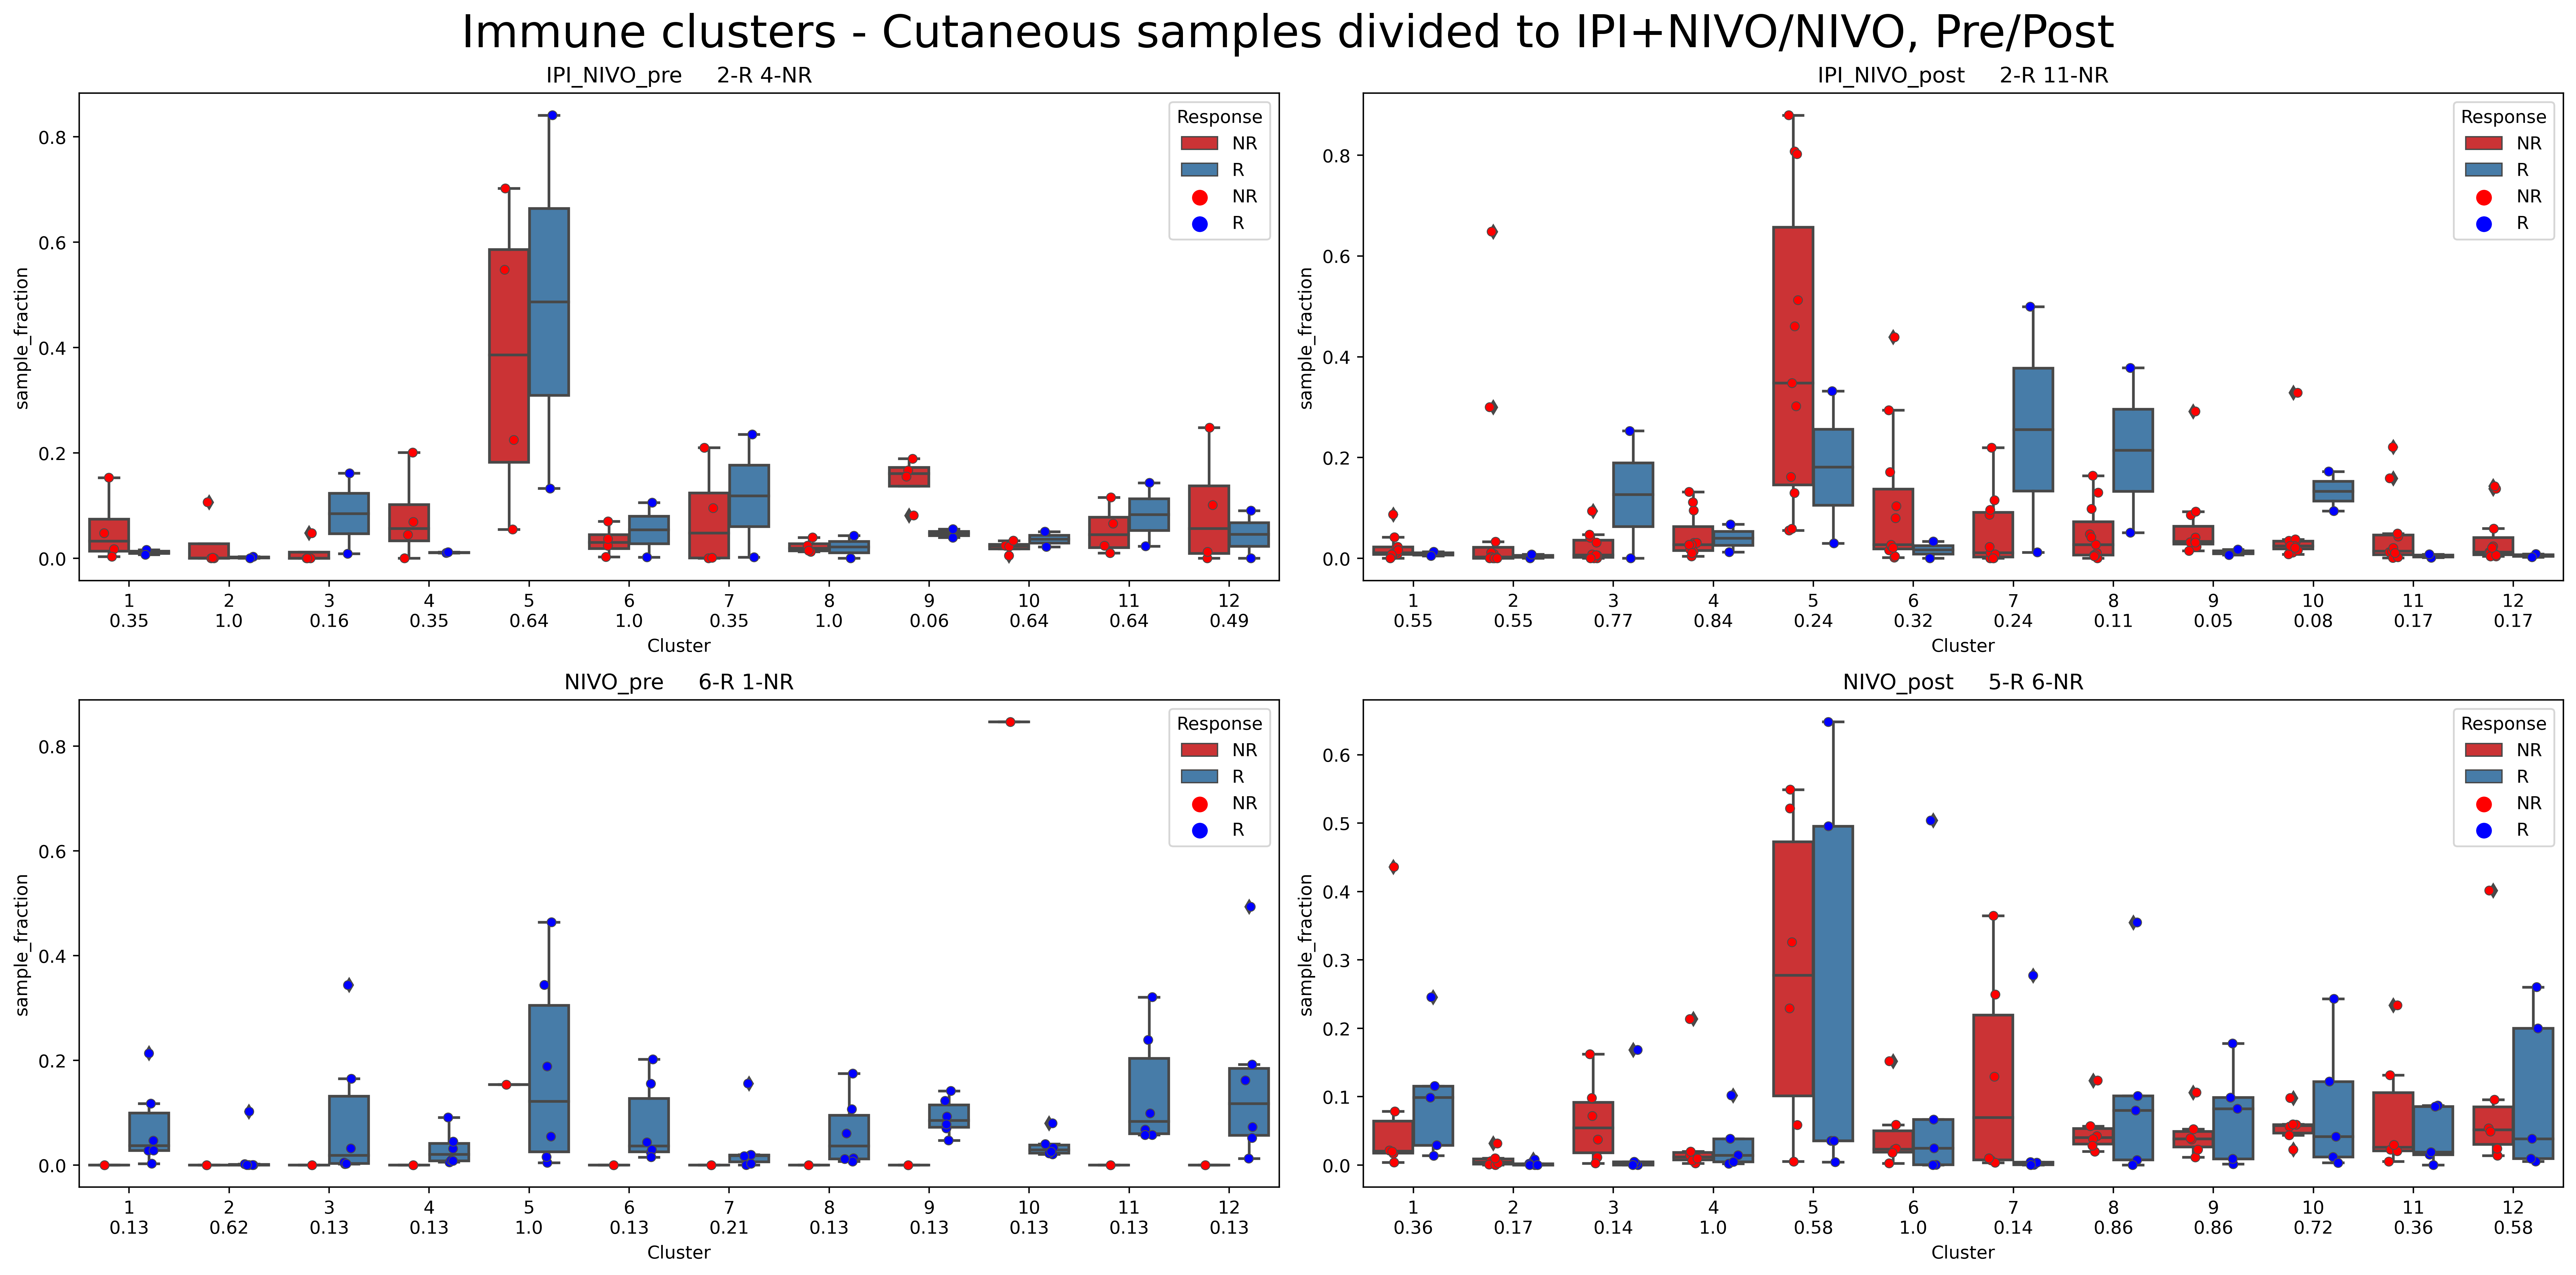

In [36]:
(fig,axes) = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()

for idx, (group_name, group_df) in enumerate(all_groups.items()):
#     print(f'{group_name}:\n{group_df["response"].value_counts()}')
    group_fractions = immune_cluster_fraction[immune_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title=group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    
fig.suptitle('Immune clusters - Cutaneous samples divided to IPI+NIVO/NIVO, Pre/Post', fontsize=25);
plt.tight_layout(pad=1)


In [16]:
out = 1984.62 + 1023.49
out

3008.1099999999997

In [18]:
returns = 180 + 120 +190 + 626
returns

1116

In [5]:
res_melanoma_clinical_data.reset_index().sort_values(['response', 'Patient id'])

Patient id Melanoma type response treatment_before treatment_after  \
2        M100     Cutaneous       NR             NIVO         nothing   
3        M114     Cutaneous       NR             NIVO            NIVO   
4        M123     Cutaneous       NR          nothing            NIVO   
7        M134     Cutaneous       NR             NIVO   other therapy   
11       M140     Cutaneous       NR             NIVO   other therapy   
13       M157     Cutaneous       NR             NIVO   other therapy   
14       M159     Cutaneous       NR             NIVO            NIVO   
5        M126     Cutaneous        R    other therapy            NIVO   
6        M130     Cutaneous        R             NIVO      NIVO + IPI   
8        M135     Cutaneous        R    other therapy            NIVO   
9        M138     Cutaneous        R             NIVO            NIVO   
10       M139     Cutaneous        R             NIVO   other therapy   
12       M156     Cutaneous        R          nothing            NIVO   
15       M160     Cutaneous        R          nothing            NIVO   
16       M163     Cutaneous        R             NIVO            NIVO   
17       M169     Cutaneous        R          nothing            NIVO   
0         M97     Cutaneous        R          nothing            NIVO   
1         M98     Cutaneous        R             NIVO   other therapy   

   pre/post treatment  
2      Post      NIVO  
3      Post      NIVO  
4       Pre      NIVO  
7      Post      NIVO  
11     Post      NIVO  
13     Post      NIVO  
14     Post      NIVO  
5       Pre      NIVO  
6      Post      NIVO  
8       Pre      NIVO  
9      Post      NIVO  
10     Post      NIVO  
12      Pre      NIVO  
15      Pre      NIVO  
16     Post      NIVO  
17      Pre      NIVO  
0       Pre      NIVO  
1      Post      NIVO